# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import cv2
import time
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


from matplotlib.backends.backend_pdf import PdfPages
from tqdm.notebook import tqdm, trange
from scipy import interpolate 
from scipy import signal
from scipy.signal import medfilt

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
sys.path.append(str(Path('~/Research/MyRepos/SensoryMotorPred/PredCoding/').expanduser()))
from util.paths import find, list_subdirs
import io_dict_to_hdf5 as ioh5



import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False, 
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import platform
if platform.system() == 'Linux':
    base_path = Path('~/NewMonster/T/BinocOptoPreyCapture/').expanduser()
    print('Running on Linux')
else:
    base_path = Path('T:/BinocOptoPreyCapture').expanduser()
    print('Running on Windows')
    
########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    ''' Created by Elliott Abe '''
    if path in basepath.as_posix():
        return basepath
    elif not (basepath / path).exists():
        (basepath / path).mkdir(exist_ok=True,parents=True)
        print('Added Directory:'+ (basepath / path).as_posix())
        return (basepath / path)
    else:
        return (basepath / path)



Running on Linux


In [2]:

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def add_colorbar(mappable,linewidth=2):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    cbar.outline.set_linewidth(linewidth)
    plt.sca(last_axes)
    return cbar

cmap_name = 'Accent'

In [3]:
def get_laser_onoff(imufile,laser_ksize=3):
    imu_data = xr.open_dataset(imufile)
    LaserT = imu_data.IMU_data.sample.data # imu timestamps
    LaserT0 = LaserT[0]
    LaserT = LaserT - LaserT0
    laser = imu_data.IMU_data.sel(channel='acc_x_raw').data # imu dample data
    dlaser = np.diff(medfilt(laser, kernel_size=laser_ksize),append=0)
    l_inds = np.where((np.abs(dlaser)>1.5))[0]
    LOn_ind = l_inds[0]
    LOff_ind = l_inds[-1]
    return LOn_ind, LOff_ind, LaserT

# Load CSV Files and Meta Data

In [ ]:
# csv_filepath = os.path.normpath('T:/OptoPreyCapture/csv_today.csv')
csv_filepath = base_path / 'csv_testing.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)

# Format Pandas Dataframe to have Trial number and Stimulus condition
cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind, row in csv.iterrows():
    for n in range(1, 6):
        if pd.isnull(row['excluded_trials'])==True :
            if 'x' in row['{:d}'.format(n)]:
                capture = False
            else:
                capture = True
            if '*' in row['{:d}'.format(n)]:
                csv2 = csv2.append(row[:-4].append(pd.Series([n, True, capture], index=['Trial', 'LaserOn','Capture'])), ignore_index=True)
            else:
                csv2 = csv2.append(row[:-4].append(pd.Series([n, False, capture], index=['Trial', 'LaserOn','Capture'])), ignore_index=True)
        elif  n in np.array(row['excluded_trials']):
            pass
inds, labels = csv2['Environment'].factorize()

# Initialize to get column names by loading in first trial
n=0
row = csv2.iloc[n]
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata

In [ ]:
# Create metadata dataframe
df_meta = pd.DataFrame(columns=list(metadata.keys()))
for ind, row in tqdm(csv2.iterrows(),total=csv2.shape[0]):
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            metadata = store.get_storer('df').attrs.metadata
            if row['LaserOn']==True:
                if (row['experiment_date'] != '091521') & (row['experiment_date'] != '091621'):
                    imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
                    Lon, Loff, LaserT = get_laser_onoff(imufile)
                    metadata['LaserOnInd'] = np.abs(data['t'] - LaserT[Lon]).argmin()
                    metadata['LaserOffInd'] = np.abs(data['t'] - LaserT[Loff]).argmin()
                    metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - LaserT[Lon]).argmin()]
                    metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - LaserT[Loff]).argmin()]
                else:
                    metadata['LaserOnInd'] = np.abs(data['t'] - 0).argmin()
                    metadata['LaserOffInd'] = np.abs(data['t'] - 30).argmin()
                    metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - 0).argmin()]
                    metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - 30).argmin()]
            else:
                metadata['LaserOnInd'] = -999
                metadata['LaserOffInd'] = -999
            metadata.update(csv2[['animal_name','experiment_date','Trial','LaserOn','Environment','Exp_Ctrl','Capture']].iloc[ind])
            df_meta = df_meta.append(metadata, ignore_index=True)
df_meta = df_meta.astype({'Trial':np.int16,'LaserOn':bool,'LaserOnInd':np.int32,'LaserOffInd':np.int32,'Capture':bool})
# Set Failed Capture Times to nan
# mask = (df_meta['Capture']==False)
# df_meta.loc[mask,'CaptureT'] = np.nan

df_meta['Cap_dur_laser'] = False
mask2=(df_meta['Capture']==True) & (df_meta['CaptureT'] > df_meta['LaserOnT']) & (df_meta['CaptureT'] < df_meta['LaserOffT'])
df_meta.loc[mask2,'Cap_dur_laser'] = True

In [8]:
df_meta.head()

,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture,dist_at_approach,Capture,Environment,Exp_Ctrl,LaserOffInd,LaserOffT,LaserOn,LaserOnInd,LaserOnT,Trial,animal_name,experiment_date,dist_at_fapproach,Cap_dur_laser
0,68.233333,68.216667,12.770970,0.307767,0.095238,0.500000,"[34.140382979037824, 29.960224406657574, 27.02...",False,Hsb,Exp,1954,32.577383,True,0,0.000000,1,PVCha2black,082521,NaN,False
1,61.216667,61.200000,9.720384,0.261367,0.125000,0.500000,"[25.884754942027026, 11.612434571196932, 23.70...",False,Hsb,Exp,-999,NaN,False,-999,NaN,2,PVCha2black,082521,NaN,False
2,53.666667,52.050000,0.349978,0.372671,0.350000,0.142857,"[14.875147789774605, 6.309327051859452, 39.332...",True,Hsb,Exp,-999,NaN,False,-999,NaN,3,PVCha2black,082521,NaN,False
3,65.266667,62.050000,2.234432,0.429009,0.392857,0.090909,"[17.326949101162935, 31.28476775277401, 31.610...",True,Hsb,Exp,1927,32.126681,True,0,0.000000,4,PVCha2black,082521,NaN,False
4,70.900000,67.600000,0.799744,0.366714,0.538462,0.071429,"[10.339304574872024, 10.211501520275284, 27.12...",True,Hsb,Exp,1854,30.909555,True,3,0.049536,5,PVCha2black,082521,NaN,False


In [9]:
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
df_meta.to_feather(SavePath/'df_meta.feather')

In [4]:
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
df_meta = pd.read_feather(SavePath/'df_meta.feather')


## Plotting by Conditions

In [92]:
row = csv2.iloc[0]
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata
    if row['LaserOn']==True:
        if (row['experiment_date'] != '091521') | (row['experiment_date'] != '091621'):
            imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
            Lon, Loff, LaserT = get_laser_onoff(imufile)
            metadata['LaserOnInd'] = data['t'].values[np.abs(data['t'] - LaserT[Lon]).argmin()]
            metadata['LaserOffInd'] = data['t'].values[np.abs(data['t'] - LaserT[Loff]).argmin()]
        else:
            metadata['LaserOnT'] = data['t'].values[np.abs(data['t'] - 0).argmin()]
            metadata['LaserOffT'] = data['t'].values[np.abs(data['t'] - 30).argmin()]

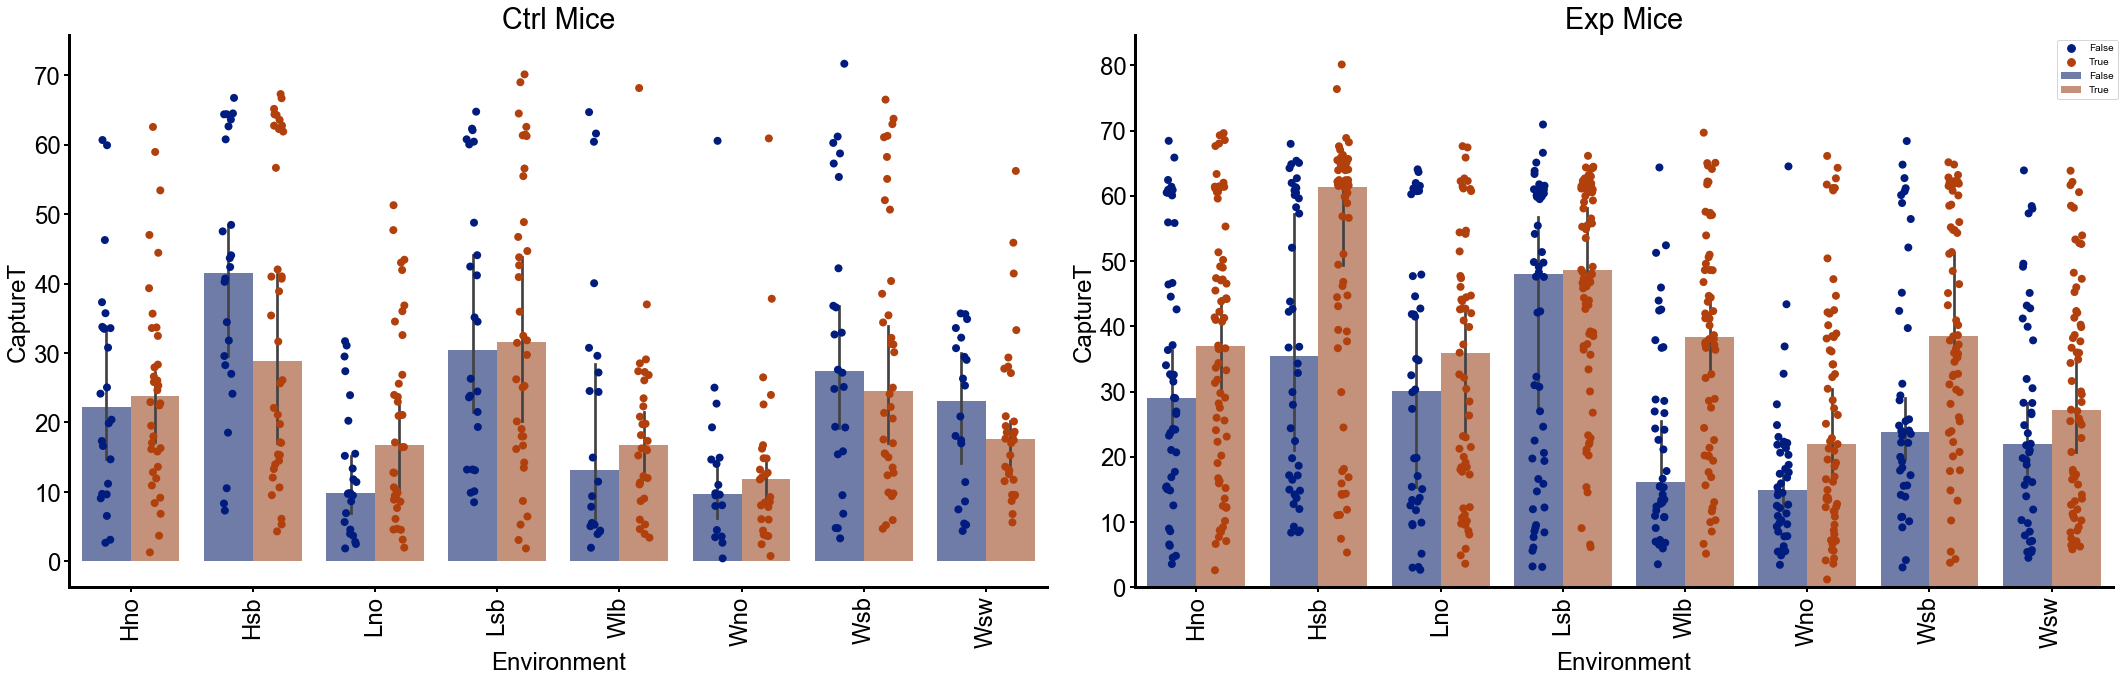

In [93]:
Metric = 'CaptureT'
fig, axs = plt.subplots(1,2,figsize=(30,10))
for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
    g = sns.barplot(data=df_meta[df_meta['Exp_Ctrl']==cond], x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                    palette="dark", alpha=.6, ax=axs[ind],order=sorted(df_meta['Environment'].unique()))
    g.set_xlabel("")
    g.set_ylabel("{}".format(Metric))
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_title('{} Mice'.format(cond))
#     sns.catplot(x="Environment", y=Metric, hue="LaserOn",kind="swarm", data=df_meta[df_meta['Exp_Ctrl']==cond],ax=axs[ind])
    sns.stripplot(x="Environment", y=Metric, hue="LaserOn", data=df_meta[df_meta['Exp_Ctrl']==cond],ax=axs[ind], palette="dark", size=8, dodge=True,order=sorted(df_meta['Environment'].unique()))
    axs[ind].legend([],[], frameon=False)
axs[ind].legend(bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()
# fig.savefig(FigPath/(Metric+'_median.png'),facecolor='white', transparent=True)


In [225]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')

pdf_name = FigPath / 'CaptureT_by_Ani.pdf'
Metric = 'CaptureT'
with PdfPages(pdf_name) as pdf:
    for ani in tqdm(df_meta['animal_name'].unique()):
        df_meta2 = df_meta[df_meta['animal_name']==ani].reset_index()
        fig, axs = plt.subplots(1,1,figsize=(10,7))
    #     for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
        g = sns.barplot(data=df_meta2, x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                        palette="dark", alpha=.6, ax=axs,order=sorted(df_meta2['Environment'].unique()))
        g.set_xlabel("")
        g.set_ylabel("{}".format(Metric))
        g.set_xticklabels(g.get_xticklabels(), rotation = 90)
        g.set_title('{}: {}'.format(ani,df_meta2['Exp_Ctrl'].unique()))
    #     sns.catplot(x="Environment", y=Metric, hue="LaserOn",kind="swarm", data=df_meta[df_meta['Exp_Ctrl']==cond],ax=axs[ind])
        sns.stripplot(x="Environment", y=Metric, hue="LaserOn", data=df_meta2,ax=axs, palette="dark", size=8, dodge=True,order=sorted(df_meta2['Environment'].unique()))
        axs.legend([],[], frameon=False)
        axs.legend(bbox_to_anchor=(1.01, 1), fontsize=10)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    # fig.savefig(FigPath/(Metric+'_median.png'),facecolor='white', transparent=True)


  0%|          | 0/9 [00:00<?, ?it/s]

# Checking Basic Params

In [143]:
n = 2
row = csv2.iloc[n]
topfile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*TOP1.nc'))[0])

animal_dir = base_path/row['experiment_date']/row['animal_name']
config_path = Path.cwd()/'config.yaml'
with open(config_path, 'r') as infile:
    config = yaml.load(infile, Loader=yaml.FullLoader)
config['animal_dir'] = animal_dir.as_posix()
# calc_params(config)

In [144]:
from project_analysis.prey_capture.calc_basic_params import calc_params, calc_basic_param_from_file


In [202]:
n=89
row = csv2.iloc[n]
topfile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*TOP1.nc'))[0])
az, spd, dist, mouse_xy, Cricket_xy, t, movieT, captureT = calc_basic_param_from_file(topfile)

# df_meta.iloc[n]['CaptureT'],captureT,movieT

In [205]:
med_filt_win=15
# find the start and end of each approach
approach  = (np.abs(az) < 30) & (spd > 5)
approach = approach.astype(int)
approach = signal.medfilt(approach, med_filt_win) # 31 is hardcoded half a second based on framerate; 15=.25*60 fps
approach = np.asarray(approach)

approachStarts = np.where(np.diff(approach)>0)
approachEnds = np.where(np.diff(approach)<0)
if np.size(approachStarts) != 0:
    firstApproach = np.min(approachStarts)
    dist_at_approach = dist[approachStarts]
    timetoapproach = t[firstApproach] # return this
else:
    firstApproach = np.nan
    dist_at_approach = np.nan
    timetoapproach = np.nan

freqapproach= np.size(approachStarts) / movieT # return this

# find instances of intercept given an approach (end of approach range <2cm); index dist using approachEnds, if range value <2, then call an intercept
maybeIntercept = np.take(dist, approachEnds) # uses approachEnds to index dist
maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
if np.size(maybeIntercept)>0:
    maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk
intercept = []
for i in maybeIntercept:
    if i < 5:
        intercept.append(1)
    else:
        intercept.append(0)

# calculate probability of intercept given approach
tot_approach = np.size(approachEnds)
tot_intercept = sum(intercept)

# calculate the probability of capture given contact - 1/number of intercepts
if tot_intercept>0:
    prob_inter = tot_intercept / tot_approach
    prob_capture = 1 / tot_intercept
else:
    prob_inter = 0
    prob_capture = 0
    print('no capture')

timetoapproach, freqapproach, prob_inter, prob_capture, dist_at_approach

(2.184320000000298,
 0.2294455066921606,
 1.0,
 0.5,
 array([14.38332385,  2.91973897]))

NameError: name 'df' is not defined

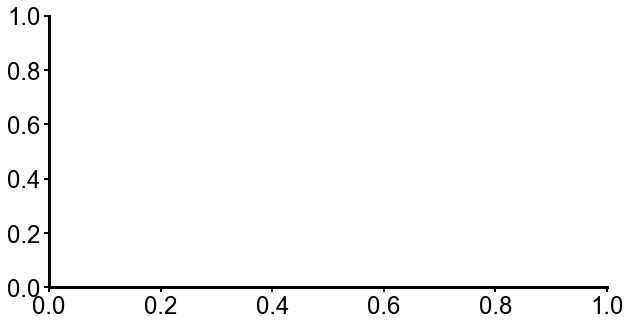

In [226]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['t'],df['Angle'], c='b')
ax.plot(df['t'],df['Speed'], c='k')
ax.plot(df['t'],df['Dist'], c='m')
ax.plot(df['t'],approach*100,c='g')
ax.axvline(x=metadata['TimeToApproach'], c='g')
ax.axvline(x=metadata['CaptureT'], c='r')
ax.set_title('Basic Params')
ax.legend(['Angle', 'Speed', 'Dist. to Cricket', 'TimeToApproach', 'CaptureT'], bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10,8))
plot_min, plot_max = np.nanmin(df[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy()), np.nanmax(df[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy())
ax.plot(df['Mouse_x'], df['Mouse_y'],c='k')
ax.plot(df['Cricket_x'], df['Cricket_y'],c='r')
ax.scatter(df['Mouse_x'].dropna().iloc[0], df['Mouse_y'].dropna().iloc[0],s=500,c='g')
ax.scatter(df['Cricket_x'].dropna().iloc[0], df['Cricket_y'].dropna().iloc[0],s=500,c='g')
ax.set_xlim([plot_min-1,plot_max+1])
ax.set_ylim([plot_min-1,plot_max+1])
# ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_title('DLC Tracking')
ax.legend(['Mouse', 'Cricket'], bbox_to_anchor=(1.01, 1), fontsize=10)
ax.set_aspect('equal', 'box')
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
plt.tight_layout()


In [16]:
trial = 5
date = '082521'
ani = 'PVCha2black'
mx = df_all.xs((date,ani,trial),level=(0,1,2))['Mouse_x'].values
my = df_all.xs((date,ani,trial),level=(0,1,2))['Mouse_y'].values
cx = df_all.xs((date,ani,trial),level=(0,1,2))['Cricket_x'].values
cy = df_all.xs((date,ani,trial),level=(0,1,2))['Cricket_y'].values

array([34.14038298, 29.96022441, 27.02690201, 19.83676641,  7.37065336,
        9.42560679, 11.86434664, 20.58361664, 13.43266515, 26.29243848,
       16.61033524, 13.11839625, 16.11489988,  9.7528411 , 23.92978726,
       21.2269121 , 34.26484828, 29.13724959, 24.59738545, 21.54715016,
        9.16268297])

# Rate of Capture Testing

In [76]:
##### Failure Trials #####
# Laser on Failure Time #
Lon_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==True)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
Lon_Fails = Lon_Fails.unstack(fill_value=0).stack()
Lon_Fails['LCapT'] = (Lon_Fails['LaserOffT']-Lon_Fails['LaserOnT'])
# Laser Off Failure Time #
Loff_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==False)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
Loff_Fails = Lon_Fails.unstack(fill_value=0).stack()
Loff_Fails['LCapT'] = (Loff_Fails['CaptureT']-Loff_Fails['LaserOffT'])

##### Success Trials #####
# Captured During Laser On time #
df1 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==True)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured during Laser on
# df1 = df1.unstack(fill_value=0).stack()
df1['LCapT'] = df1['CaptureT'] - df1['LaserOnT'] # amount of time laser on 
# Captured During Laser off Time # 
df2 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured after laser off
# df2 = df2.unstack(fill_value=0).stack()
df2['LCapT'] = df2['CaptureT'] - df2['LaserOffT'] # amount of time laser off
# Captured during NO Laser Trials 
df3 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==False)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT']] # Non Laser Caputure
# df3 = df3.unstack(fill_value=0).stack()
df3['LCapT'] = df3['CaptureT'].copy()

##### LaserOnCapture Count #####
Lon_count = df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count()
##### LaserOnCapture Time + LaserOnFail Times #####
Lon_T = (df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum() + Lon_Fails[['LCapT']])
##### LaserOffCapture Count + NoLaser Count #####
Loff_count = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count().unstack(fill_value=0).stack() + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count())
##### LaserOffCapture Time + LaserOffFails Time + NoLaser Time #####
Loff_T = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum().unstack(fill_value=0).stack()  + Loff_Fails[['LCapT']] + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum())

In [95]:
# df1b = (Lon_count/Lon_T).reset_index()
# df1b['LaserOn'] = True
# df2b = (Loff_count/Loff_T).reset_index()
# df2b['LaserOn'] = False
# df_CapT = pd.concat((df1b,df2b),axis=0)
# df_CapT

In [77]:
df1b = (Lon_T/Lon_count).reset_index()
df1b['LaserOn'] = True
df2b = (Loff_T/Loff_count).reset_index()
df2b['LaserOn'] = False
df_CapT = pd.concat((df1b,df2b),axis=0)
# df_CapT

Time per capture for each animal then average across animals. errorbars

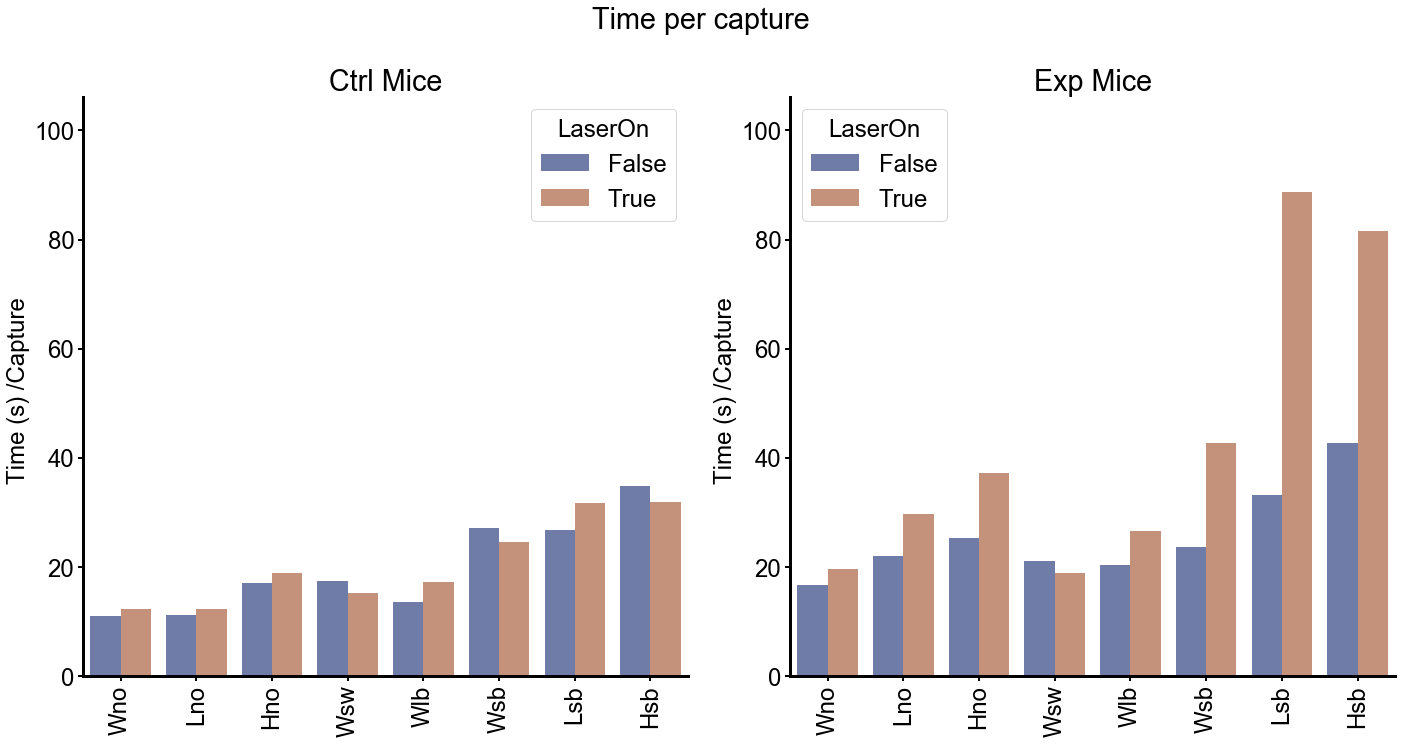

In [83]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]
Metric = 'LCapT'
fig, axs = plt.subplots(1,2,figsize=(20,10))
for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
    g = sns.barplot(data=df_CapT[df_CapT['Exp_Ctrl']==cond], x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                    ci='sd', palette="dark", alpha=.6, ax=axs[ind],order=order)
    g.set_xlabel("")
    g.set_ylabel("{}".format('Time (s) /Capture '))
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_title('{} Mice'.format(cond))
    g.set_ylim(0, df_CapT['LCapT'].max() + df_CapT['LCapT'].std())#.3)
plt.suptitle('Time per capture',y=1.05)
plt.tight_layout()
# fig.savefig(FigPath/'TimeperCapture.png', facecolor='white', transparent=True)

prob of initiating vs prob of intercept after initiation

distance at approach onset

defining approaches: hmm and jen's method

Trajectory/angle of head at approach. 

Speed during approach 

Angle during approach

body point: displacement of the body as vector. is center point moving towards cricket

distance to the walls. 2d hist of where mice are. 

interp of cricket: interp cricket location based on distance to mouse for kinematic variables. tkae out nan in beginning and end then interp. 

In [ ]:
# n=np.random.randint(0,len(df_cap))
n=0
trial = df['Trial'].iloc[n]
date = df['experiment_date'].iloc[n]
ani = df['animal_name'].iloc[n]
lon = df['LaserOnInd'].iloc[n]
loff = df['LaserOffInd'].iloc[n]
print('{}, {}, {}, {}'.format(n,date,ani,trial))
mx = df.xs((date,ani,trial),level=(0,1,2))['Mouse_x'].values
my = df.xs((date,ani,trial),level=(0,1,2))['Mouse_y'].values
cx = df.xs((date,ani,trial),level=(0,1,2))['Cricket_x'].values
cy = df.xs((date,ani,trial),level=(0,1,2))['Cricket_y'].values
ang = df.xs((date,ani,trial),level=(0,1,2))['Angle_norm'].values
spd = df.xs((date,ani,trial),level=(0,1,2))['Speed_norm'].values
dist = df.xs((date,ani,trial),level=(0,1,2))['Dist_norm'].values
# lab = df.xs((date,ani,trial),level=(0,1,2))['hmm_states'].values
t = df.xs((date,ani,trial),level=(0,1,2))['t'].values 

df_trial = df_meta[((df_meta['experiment_date']==date)&(df_meta['animal_name']==ani)&(df_meta['Trial']==trial))]
# csv2[(csv2['animal_name']==ani) & (csv2['experiment_date']==date) & (csv2['Trial']==trial)]
df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]

## Time Per Capture Per mouse

In [233]:
##### Failure Trials #####
# Laser on Failure Time #
Lon_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==True)][['animal_name','Environment','CaptureT','LaserOnT','LaserOffT']]).groupby(['animal_name','Environment']).sum())#.reset_index()
Lon_Fails = Lon_Fails.unstack(fill_value=0).stack()
Lon_Fails['LCapT'] = (Lon_Fails['LaserOffT']-Lon_Fails['LaserOnT'])
# Laser Off Failure Time #
Loff_Fails = ((df_meta[(df_meta['Capture']==False)&(df_meta['LaserOn']==False)][['animal_name','Environment','CaptureT','LaserOnT','LaserOffT']]).groupby(['animal_name','Environment']).sum())#.reset_index()
Loff_Fails = Lon_Fails.unstack(fill_value=0).stack()
Loff_Fails['LCapT'] = (Loff_Fails['CaptureT']-Loff_Fails['LaserOffT'])

##### Success Trials #####
# Captured During Laser On time #
df1 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==True)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured during Laser on
# df1 = df1.unstack(fill_value=0).stack()
df1['LCapT'] = df1['CaptureT'] - df1['LaserOnT'] # amount of time laser on 
# Captured During Laser off Time # 
df2 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured after laser off
# df2 = df2.unstack(fill_value=0).stack()
df2['LCapT'] = df2['CaptureT'] - df2['LaserOffT'] # amount of time laser off
# Captured during NO Laser Trials 
df3 = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==False)&(df_meta['LaserOn']==False)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT']] # Non Laser Caputure
# df3 = df3.unstack(fill_value=0).stack()
df3['LCapT'] = df3['CaptureT'].copy()

##### LaserOnCapture Count #####
Lon_count = df1[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).count().dropna()
##### LaserOnCapture Time + LaserOnFail Times #####
Lon_T = (df1[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).sum() + Lon_Fails[['LCapT']])
##### LaserOffCapture Count + NoLaser Count #####
Loff_count = (df2[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).count().unstack(fill_value=0).stack() + df3[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).count()).dropna()
##### LaserOffCapture Time + LaserOffFails Time + NoLaser Time #####
Loff_T = (df2[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).sum().unstack(fill_value=0).stack()  + Loff_Fails[['LCapT']] + df3[['animal_name','Exp_Ctrl','Environment','LCapT']].groupby(['animal_name','Environment','Exp_Ctrl']).sum())

df1b = (Lon_T/Lon_count).reset_index()
df1b['LaserOn'] = True
df2b = (Loff_T/Loff_count).reset_index()
df2b['LaserOn'] = False
df_CapT = pd.concat((df1b,df2b),axis=0)
# df_CapT


In [234]:
Lon_count.reset_index()

,animal_name,Environment,Exp_Ctrl,LCapT
0,PV154black,Hno,Ctrl,8
1,PV154black,Hsb,Ctrl,4
2,PV154black,Lno,Ctrl,6
3,PV154black,Lsb,Ctrl,4
4,PV154black,Wlb,Ctrl,6
5,PV154black,Wno,Ctrl,5
6,PV154black,Wsb,Ctrl,4
7,PV154black,Wsw,Ctrl,7
8,PV154pink,Hno,Ctrl,7
9,PV154pink,Hsb,Ctrl,3


In [235]:
len(Lon_count.reset_index()['animal_name'].unique())*len(Lon_count.reset_index()['Environment'].unique())

72

In [236]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')

pdf_name = FigPath / 'TimePerCapture_by_Ani.pdf'
with PdfPages(pdf_name) as pdf:
    for ani in tqdm(df_meta['animal_name'].unique()):
#         df_meta2 = df_meta[df_meta['animal_name']==ani].reset_index()
#         ##### Failure Trials #####
#         # Laser on Failure Time #
#         Lon_Fails = ((df_meta2[(df_meta2['Capture']==False)&(df_meta2['LaserOn']==True)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
#         Lon_Fails = Lon_Fails.unstack(fill_value=0).stack()
#         Lon_Fails['LCapT'] = (Lon_Fails['LaserOffT']-Lon_Fails['LaserOnT'])
#         # Laser Off Failure Time #
#         Loff_Fails = ((df_meta2[(df_meta2['Capture']==False)&(df_meta2['LaserOn']==False)][['Environment','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']]).groupby(['Environment','Exp_Ctrl']).sum())#.reset_index()
#         Loff_Fails = Lon_Fails.unstack(fill_value=0).stack()
#         Loff_Fails['LCapT'] = (Loff_Fails['CaptureT']-Loff_Fails['LaserOffT'])

#         ##### Success Trials #####
#         # Captured During Laser On time #
#         df1 = df_meta2[(df_meta2['Capture']==True)&(df_meta2['Cap_dur_laser']==True)&(df_meta2['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured during Laser on
#         # df1 = df1.unstack(fill_value=0).stack()
#         df1['LCapT'] = df1['CaptureT'] - df1['LaserOnT'] # amount of time laser on 
#         # Captured During Laser off Time # 
#         df2 = df_meta2[(df_meta2['Capture']==True)&(df_meta2['Cap_dur_laser']==False)&(df_meta2['LaserOn']==True)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT','LaserOnT','LaserOffT']] # Captured after laser off
#         # df2 = df2.unstack(fill_value=0).stack()
#         df2['LCapT'] = df2['CaptureT'] - df2['LaserOffT'] # amount of time laser off
#         # Captured during NO Laser Trials 
#         df3 = df_meta2[(df_meta2['Capture']==True)&(df_meta2['Cap_dur_laser']==False)&(df_meta2['LaserOn']==False)][['animal_name','Environment','Trial','Exp_Ctrl','CaptureT']] # Non Laser Caputure
#         # df3 = df3.unstack(fill_value=0).stack()
#         df3['LCapT'] = df3['CaptureT'].copy()


#         ##### LaserOnCapture Count #####
#         Lon_count = df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count()
#         ##### LaserOnCapture Time + LaserOnFail Times #####
#         Lon_T = (df1[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum() + Lon_Fails[['LCapT']])
#         ##### LaserOffCapture Count + NoLaser Count #####
#         Loff_count = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count().unstack(fill_value=0).stack() + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).count())
#         ##### LaserOffCapture Time + LaserOffFails Time + NoLaser Time #####
#         Loff_T = (df2[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum().unstack(fill_value=0).stack()  + Loff_Fails[['LCapT']] + df3[['Exp_Ctrl','Environment','LCapT']].groupby(['Environment','Exp_Ctrl']).sum())

#         df1b = (Lon_T/Lon_count).reset_index()
#         df1b['LaserOn'] = True
#         df2b = (Loff_T/Loff_count).reset_index()
#         df2b['LaserOn'] = False
#         df_CapT = pd.concat((df1b,df2b),axis=0)
#         # df_CapT

        Metric = 'LCapT'
        fig, axs = plt.subplots(1,1,figsize=(10,7))
    #     for ind, cond in enumerate(np.unique(df_meta2['Exp_Ctrl'])):
        g = sns.barplot(data=df_CapT[df_CapT['animal_name']==ani], x="Environment", y=Metric, hue="LaserOn", estimator=np.median,
                        ci='sd', palette="dark", alpha=.6, ax=axs,order=sorted(df_CapT['Environment'].unique()))
        g.set_xlabel("")
        g.set_ylabel("{}".format('Time (s) /Capture '))
        g.set_xticklabels(g.get_xticklabels(), rotation = 90)
#         g.set_title('{} Mice'.format(cond))
        g.set_ylim(0, df_CapT['LCapT'].max() + df_CapT['LCapT'].std())#.3)
        g.set_title('{}: {}'.format(ani,df_CapT[df_CapT['animal_name']==ani].dropna()['Exp_Ctrl'].unique()))
        plt.suptitle('Time per capture',y=1.05)
        plt.tight_layout()
        pdf.savefig()
        plt.close()
# fig.savefig(FigPath/'TimeperCapture.png', facecolor='white', transparent=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [105]:
df_CapT[df_CapT['animal_name']==ani].dropna()

,animal_name,Environment,Exp_Ctrl,LCapT,LaserOn
0,PV154black,Hno,Ctrl,22.479316,True
1,PV154black,Hsb,Ctrl,29.246658,True
2,PV154black,Lno,Ctrl,9.024824,True
3,PV154black,Lsb,Ctrl,44.582868,True
4,PV154black,Wlb,Ctrl,12.830206,True
5,PV154black,Wno,Ctrl,26.365682,True
6,PV154black,Wsb,Ctrl,33.209172,True
7,PV154black,Wsw,Ctrl,18.104552,True
0,PV154black,Hno,Ctrl,23.271657,False
2,PV154black,Hsb,Ctrl,33.852130,False


# Prob of Capture first 30s

In [219]:
trial = 1
date = '083021'
ani = 'PVCha2black'
df_trial = df_all.xs((date,ani,trial),level=(0,1,2)).reset_index()
mx = df_trial['Mouse_x'].values
my = df_trial['Mouse_y'].values
cx = df_trial['Cricket_x'].values
cy = df_trial['Cricket_y'].values
Laser = df_trial['LaserOn'].values
t = df_trial['t'].values
df_meta[(df_meta['animal_name']==ani)&(df_meta['experiment_date']==date)]


,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture,dist_at_approach,Capture,Environment,Exp_Ctrl,LaserOffInd,LaserOffT,LaserOn,LaserOnInd,LaserOnT,Trial,animal_name,experiment_date,Cap_dur_laser
135,66.150000,66.133333,6.068903,0.362812,0.125000,0.333333,"[9.630666929401066, 17.51582305072764, 17.0055...",False,Lsb,Exp,1853,30.893888,True,1,0.017549,1,PVCha2black,083021,False
136,21.200000,14.550000,2.101133,0.283019,0.333333,0.500000,"[6.253163521901671, 3.1875080299477525, 18.721...",True,Lsb,Exp,1134,18.906637,True,8,0.134400,2,PVCha2black,083021,True
137,57.916667,55.250000,0.584153,0.397122,0.347826,0.125000,"[14.599249055690365, 11.58856332387229, 2.3240...",True,Lsb,Exp,1820,30.343859,True,0,0.000000,3,PVCha2black,083021,False
138,60.700000,60.683333,3.184691,0.411862,0.360000,0.111111,"[20.864039681765473, 24.70535405438583, 25.101...",False,Lsb,Exp,-999,NaN,False,-999,NaN,4,PVCha2black,083021,False
139,51.200000,49.766667,0.199706,0.273438,0.428571,0.166667,"[14.13666183447399, 8.059304352332521, 23.4958...",True,Lsb,Exp,-999,NaN,False,-999,NaN,5,PVCha2black,083021,False


In [220]:
mx_30 = mx[t<30]
my_30 = my[t<30]
cx_30 = cx[t<30]
cy_30 = cy[t<30]
asd = df_trial[['Angle','Speed','Dist']].iloc[t<30].values

(35.401538187882, 0.1989846755718363)

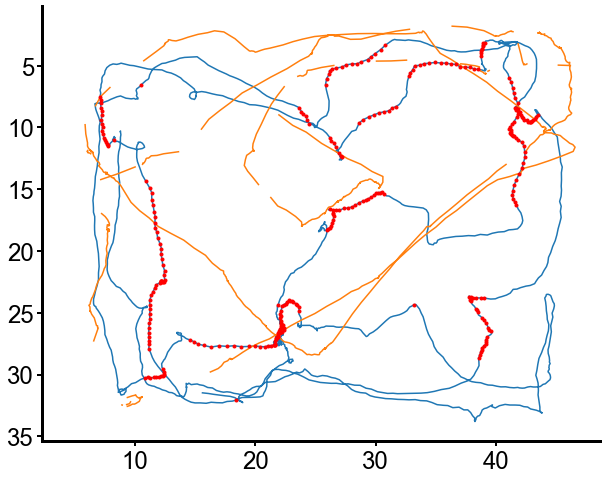

In [221]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(mx_30,my_30)
ax.plot(cx_30,cy_30)
approach  = (np.abs(asd[:,0]) < 30) & (asd[:,1] > 5)

ax.plot(mx_30[approach],my_30[approach],'r.')
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis


In [113]:
med_filt_win=15
approach  = (np.abs(asd[:,0]) < 30) & (asd[:,1] > 5)
approach = approach.astype(int)
approach = signal.medfilt(approach, med_filt_win) # 31 is hardcoded half a second based on framerate; 15=.25*60 fps
approach = np.asarray(approach)

approachStarts = np.where(np.diff(approach)>0)
approachEnds = np.where(np.diff(approach)<0)
if np.size(approachStarts) != 0:
    firstApproach = np.min(approachStarts)
    dist_at_approach = asd[approachStarts,2]
    timetoapproach = t[firstApproach] # return this
else:
    firstApproach = np.nan
    dist_at_approach = np.nan
    timetoapproach = np.nan

freqapproach= np.size(approachStarts) / 30 # return this

# find instances of intercept given an approach (end of approach range <2cm); index dist using approachEnds, if range value <2, then call an intercept
maybeIntercept = np.take(asd[:,2], approachEnds) # uses approachEnds to index dist
maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
if np.size(maybeIntercept)>0:
    maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk
intercept = []
for i in maybeIntercept:
    if i < 5:
        intercept.append(1)
    else:
        intercept.append(0)

# calculate probability of intercept given approach
tot_approach = np.size(approachEnds)
tot_intercept = sum(intercept)

# calculate the probability of capture given contact - 1/number of intercepts
if tot_intercept>0:
    prob_inter = tot_intercept / tot_approach
    prob_capture = 1 / tot_intercept
else:
    prob_inter = 0
    prob_capture = 0
    print('no capture')
timetoapproach, freqapproach, prob_inter, prob_capture, dist_at_approach

(4.101363999994646,
 0.4666666666666667,
 0.38461538461538464,
 0.2,
 array([[19.65965315, 18.99147173, 22.26938929, 22.1317222 , 28.68376279,
         10.09436978,  6.08803002, 17.07188577,  4.47943079,  2.25418215,
          4.53124002, 35.05065906, 19.86286733,  3.73032424]]))

In [117]:
Cap_woL = df2['CaptureT'] - df2['LaserOffT']
# len(Cap_woL)/np.sum(Cap_woL)

In [118]:
Cap_wL = df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==True)&(df_meta['LaserOn']==True)]['CaptureT'].values - df_meta[(df_meta['Capture']==True)&(df_meta['Cap_dur_laser']==True)&(df_meta['LaserOn']==True)]['LaserOnT'].values
len(Cap_wL)/np.sum(Cap_wL)

0.0650173951499141

In [229]:
anis_lon = df_meta[(df_meta['LaserOn']==True)&(df_meta['Exp_Ctrl']=='Exp')&(df_meta['Capture']==True)]['animal_name'].unique().tolist()
anis_loff = df_meta[df_meta['LaserOn']==False]['animal_name'].unique().tolist()

In [224]:
idx = pd.IndexSlice


In [233]:
anis_lon

['PVCha2black',
 'PVCha2green',
 'PVCha3white',
 'PVCha3black',
 'PVCha5Agreen',
 'PVCha5Ablack']

In [230]:
laseron_df = df_all.loc[idx[:,anis_lon,:],['LaserOn','t']]

In [254]:
from scipy.stats import binned_statistic

In [257]:
stat, edges, _ = binned_statistic(df['Angle'], df['Speed'], statistic='mean')

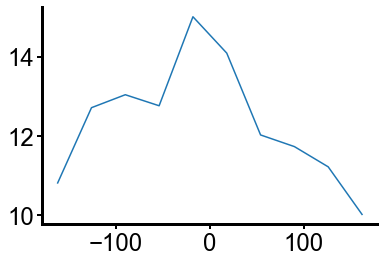

In [259]:
edge_mids = [(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)]
plt.plot(edge_mids,stat)

In [278]:
counts,bins,hist = axs[1].hist(df['Speed'],bins=100)
counts[:40], bins[:40]

(array([9.5495e+04, 5.3469e+04, 4.5207e+04, 4.1485e+04, 4.1653e+04,
        4.1724e+04, 4.1544e+04, 4.0847e+04, 3.8782e+04, 3.4712e+04,
        3.0563e+04, 2.6056e+04, 2.1799e+04, 1.7373e+04, 1.2752e+04,
        8.8130e+03, 5.9410e+03, 3.6710e+03, 2.0330e+03, 1.0310e+03,
        5.3100e+02, 2.1800e+02, 9.0000e+01, 5.6000e+01, 3.1000e+01,
        1.0000e+01, 7.0000e+00, 1.0000e+01, 1.6000e+01, 6.0000e+00,
        7.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00, 1.4000e+01,
        7.0000e+00, 9.0000e+00, 1.2000e+01, 0.0000e+00, 1.0000e+00]),
 array([5.06367745e-04, 2.04385550e+00, 4.08720462e+00, 6.13055375e+00,
        8.17390288e+00, 1.02172520e+01, 1.22606011e+01, 1.43039503e+01,
        1.63472994e+01, 1.83906485e+01, 2.04339976e+01, 2.24773468e+01,
        2.45206959e+01, 2.65640450e+01, 2.86073942e+01, 3.06507433e+01,
        3.26940924e+01, 3.47374415e+01, 3.67807907e+01, 3.88241398e+01,
        4.08674889e+01, 4.29108380e+01, 4.49541872e+01, 4.69975363e+01,
        4.90408854e+01

In [266]:
counts[-10:]

array([5., 3., 2., 1., 4., 0., 3., 0., 0., 1.])

# HMM/Clustering Testing

In [7]:
import ssm
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import mode

In [8]:
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df'].copy()
    

In [122]:
df_all = pd.DataFrame()
for ind, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            data['animal_name'] = row['animal_name']
            data['experiment_date'] = row['experiment_date']
            data['Trial'] = row['Trial']
            data['GroupNum'] = ind
            data['Environment'] = row['Environment']
            # threshold out outlaiers 
            data['Angle'].where(~(data['Angle']>180),np.nan,inplace=True)            
            data['Speed'].where(~(data['Speed']>50),np.nan,inplace=True)            
            data['Dist'].where(~(data['Dist']>50),np.nan,inplace=True)            
            data['Angle_norm'] = data['Angle'].copy()/180
            data['Speed_norm'] = data['Speed'].copy()/50
            data['Dist_norm'] = data['Dist'].copy()/50
            temp_laser = np.zeros((len(data)),dtype=bool)
            if row['LaserOn']==True:
                if (row['experiment_date'] != '091521') & (row['experiment_date'] != '091621'):
                    imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
                    Loni, Loffi, LaserT = get_laser_onoff(imufile)
                    Lon = np.abs(data['t'] - LaserT[Loni]).argmin()
                    Loff = np.abs(data['t'] - LaserT[Loffi]).argmin()
                    temp_laser[Lon:Loff]=True
                    data['LaserOn'] = temp_laser
                else:
                    Lon = np.abs(data['t'] - 0).argmin()
                    Loff = np.abs(data['t'] - 30).argmin()
                    temp_laser[Lon:Loff]=True
                    data['LaserOn'] = temp_laser
            else:
                data['LaserOn'] = temp_laser
            if row['Exp_Ctrl'] == 'Exp':
                data['ExpAni'] = True
            else:
                data['ExpAni'] = False
            data.set_index(['experiment_date','animal_name','Trial'],inplace=True)
            df_all = df_all.append(data.copy())


  0%|          | 0/1305 [00:00<?, ?it/s]

In [154]:
# FigPath_models = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/K{}'.format(K))
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
df_all2 = df_all.reset_index()
df_all2.to_feather(SavePath/'df_all.feather')

In [5]:
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
df_all = pd.read_feather(SavePath/'df_all.feather')
df_all = df_all.set_index(['experiment_date','animal_name','Trial'])
df = df_all.dropna()

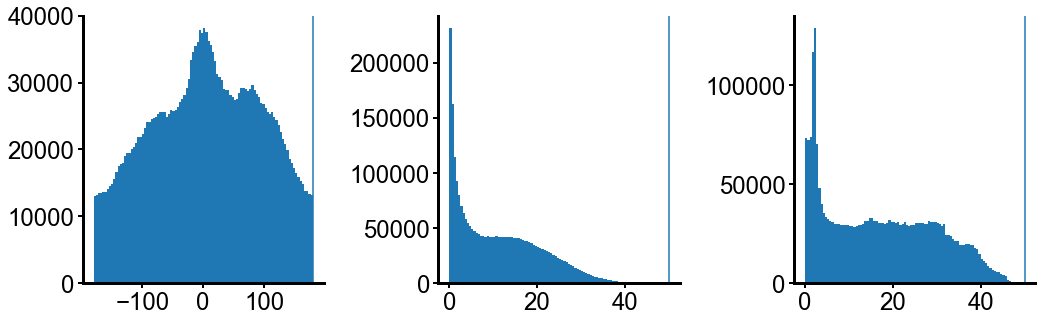

In [34]:
# Histograms for the Thresholding state variables
fig, axs = plt.subplots(1,3, figsize=(15,5))
counts,bins,hist = axs[0].hist(df_all['Angle'],bins=100)
axs[0].axvline(x=180)
counts,bins,hist = axs[1].hist(df_all['Speed'],bins=100)
axs[1].axvline(x=50)
counts,bins,hist = axs[2].hist(df_all['Dist'],bins=100)
axs[2].axvline(x=50)
plt.tight_layout()

Histograms on each condition

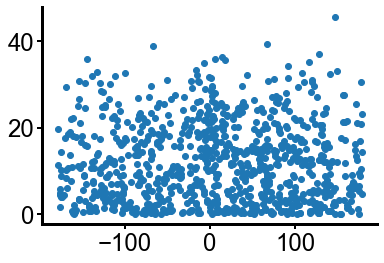

In [26]:
inds = sorted(np.random.choice(np.arange(0,embedding.shape[0]),1000))

plt.scatter(df_all['Angle'].to_numpy()[inds],df_all['Speed'].to_numpy()[inds])

In [131]:
X = df[['Angle_norm','Speed_norm','Dist_norm']].values
X[:,0] = np.abs(X[:,0])
X.shape

(2061787, 3)

## Histograms

In [164]:
df.head()

Angle     Speed       Dist   Mouse_x  \
experiment_date animal_name Trial                                             
082521          PVCha2black 1     -22.951467  0.116312  20.761324  7.571586   
                            1     -22.393889  0.039550  18.985130  7.554922   
                            1      -9.550244  0.182478  12.951043  7.573205   
                            1      -2.750227  0.119839  11.486301  7.566575   
                            1       7.437414  0.048882  10.352051  7.567440   

                                     Mouse_y  Cricket_x  Cricket_y         t  \
experiment_date animal_name Trial                                              
082521          PVCha2black 1      26.037581   6.394965   5.309625  0.468148   
                            1      26.072119   6.899012   7.098323  0.483725   
                            1      26.051174   9.967942  13.323458  0.534656   
                            1      26.042998  11.072731  15.104900  0.551655   
                            1      26.042762  12.297671  16.834621  0.567540   

                                   GroupNum Environment  Angle_norm  \
experiment_date animal_name Trial                                     
082521          PVCha2black 1             0         Hsb   -0.127508   
                            1             0         Hsb   -0.124410   
                            1             0         Hsb   -0.053057   
                            1             0         Hsb   -0.015279   
                            1             0         Hsb    0.041319   

                                   Speed_norm  Dist_norm  LaserOn  ExpAni  
experiment_date animal_name Trial                                          
082521          PVCha2black 1        0.002326   0.415226     True    True  
                            1        0.000791   0.379703     True    True  
                            1        0.003650   0.259021     True    True  
                            1        0.002397   0.229726     True    True  
                            1        0.000978   0.207041     True    True

In [375]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')

hbins = 100
# Histograms for the Thresholding state variables
metrics = ['Angle','Speed','Dist']
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]

pdf_name = FigPath / 'Metric_Hist_by_Env.pdf'
with PdfPages(pdf_name) as pdf:
    for env in tqdm(order):
        fig, axs = plt.subplots(3,2, figsize=(15,20),sharey='row')
        for n in range(axs.shape[0]):
            for m, Exp in enumerate([True,False]):
                hist_data_Lon = df[(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()[metrics[n]]
                hist_data_Loff = df[(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()[metrics[n]]
                hbin_edges1 = np.linspace(np.min(hist_data_Lon),np.max(hist_data_Lon),hbins)
                hbin_edges2 = np.linspace(np.min(hist_data_Loff),np.max(hist_data_Loff),hbins)
                count1,edges1 = np.histogram(hist_data_Lon,bins=hbin_edges1)            
                count2,edges2 = np.histogram(hist_data_Loff,bins=hbin_edges2)
                edges_mid1 = np.array([(edges1[i]+edges1[i+1])/2 for i in range(len(edges1)-1)])
                edges_mid2 = np.array([(edges2[i]+edges2[i+1])/2 for i in range(len(edges2)-1)])
                axs[n,m].bar(edges_mid1, count1/hist_data_Lon.shape[0],color='g',width=np.mean(np.diff(hbin_edges1)),alpha=.5, label='LaserOn')
                axs[n,m].bar(edges_mid2, count2/hist_data_Loff.shape[0],color='r',width=np.mean(np.diff(hbin_edges2)),alpha=.5, label='LaserOff')
                axs[n,m].set_xlabel('{}'.format(metrics[n]))
#                 axs[n,m].set_ylim(0,np.max((count1/hist_data_Lon.shape[0],count2/hist_data_Loff.shape[0])))
        axs[0,0].set_title('Exp. Anis')
        axs[0,1].set_title('Ctrl. Anis')
        axs[0,1].legend()
        plt.suptitle(env)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

  0%|          | 0/8 [00:00<?, ?it/s]

In [194]:
Exp = True
env = 'Lsb'
data1 = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['Environment']==env)].reset_index()

In [215]:
hist_data_Lon = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()
hist_data_Loff = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()


In [ ]:
inds = sorted(np.random.choice(np.arange(0,X.shape[0]),1000))
fig = px.scatter_matrix(data1,
                        dimensions=['Angle','Speed','Dist',],
                        color='LaserOn',
#                         size=1,
                        opacity=0.5)
fig.update_traces(diagonal_visible=False,
                  marker=dict(size=1,opacity=.5))
                  
fig.update_layout(width=1000,
                  height=1000,
                  )
fig.show()

In [14]:
h2dbins=10
metrics = ['Angle','Speed','Dist']
perms = np.array(list(itertools.combinations(np.arange(len(metrics)), 2)))
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]

hist_data_all = np.zeros((h2dbins,h2dbins,2,2,perms.shape[0],len(order)))# (bin x bin x Exp x LaserOn x Comb x Env)
xedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
yedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
for en, env in enumerate(tqdm(order)):
    for n in range(perms.shape[0]):
        for m, Exp in enumerate([True,False]):
            hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()
            hist_data_Loff = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()
            H_on,xedges_on,yedges_on = np.histogram2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=h2dbins, density=True)
            H_off,xedges_off,yedges_off = np.histogram2d(hist_data_Loff[metrics[perms[n,0]]],hist_data_Loff[metrics[perms[n,1]]],bins=10, density=True)
            hist_data_all[:,:,0,m,n,en] = H_on
            hist_data_all[:,:,1,m,n,en] = H_off
            xedges_all[:,0,m,n,en] = xedges_on
            xedges_all[:,1,m,n,en] = xedges_off
            yedges_all[:,0,m,n,en] = yedges_on
            yedges_all[:,1,m,n,en] = yedges_off

  0%|          | 0/8 [00:00<?, ?it/s]

In [374]:
perms = np.array(list(itertools.combinations(np.arange(len(metrics)), 2)))
metrics = ['Angle','Speed','Dist']
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]

pdf_name = FigPath / 'Metric_2dHist_by_Env.pdf'
with PdfPages(pdf_name) as pdf:
    for en,env in enumerate(tqdm(order)):
        fig,axs = plt.subplots(3,4,figsize=(25,15))
        for n in range(perms.shape[0]):
            clim = (hist_data_all[:,:,:,:,n,en].min(),hist_data_all[:,:,:,:,n,en].max())
            for m,Exp in zip([0,2],[True,False]):
                hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()
                h_on,xbins_on,ybins_on,im_on, = axs[n,m].hist2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=10, density=True,vmin=clim[0],vmax=clim[1])
                axs[n,m].set_xlabel(metrics[perms[n,0]])
                axs[n,m].set_ylabel(metrics[perms[n,1]])
                axs[n,m].set_title('LaserOn,Exp:{}'.format(Exp),fontsize=20)
#                 cbar_on = add_colorbar(im_on)
            for m,Exp in zip([1,3],[True,False]):
                hist_data_Loff = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()
                h_off,xbins_off,ybins_off,im_off, = axs[n,m].hist2d(hist_data_Loff[metrics[perms[n,0]]],hist_data_Loff[metrics[perms[n,1]]],bins=10, density=True,vmin=clim[0],vmax=clim[1])
                axs[n,m].set_xlabel(metrics[perms[n,0]])
                axs[n,m].set_ylabel(metrics[perms[n,1]])
                axs[n,m].set_title('LaserOff,Exp:{}'.format(Exp),fontsize=20)
                cbar_off = add_colorbar(im_off)
        plt.suptitle(env)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
fig = px.scatter(
    data1, x='Angle', y='Speed',
    marginal_x='histogram', marginal_y='histogram',
    color='LaserOn', 
)
fig.update_traces(histnorm='probability', selector={'type':'histogram'},)
# fig.add_shape(
#     type="line", line=dict(dash='dash'),
#     x0=data1['Angle'].min(), y0=data1['Speed'].min(),
#     x1=data1['Angle'].max(), y1=data1['Speed'].max()
# )
fig.show()

### Animations

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from celluloid import Camera

In [ ]:
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
df_meta = pd.read_feather(SavePath/'df_meta.feather')
df_all = pd.read_feather(SavePath/'df_all.feather')
df_all = df_all.set_index(['experiment_date','animal_name','Trial'])
df = df_all.dropna()
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/')
blue_patch = mpatches.Patch(color='blue', label='Angle')
black_patch = mpatches.Patch(color='black', label='Speed')
m_patch = mpatches.Patch(color='m', label='Dist')
metrics = ['Angle','Speed','Dist']
perms = np.array(list(itertools.combinations(np.arange(len(metrics)), 2)))
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]

In [ ]:

##### Histogram data #####
h2dbins=10
hist_data_all = np.zeros((h2dbins,h2dbins,2,2,perms.shape[0],len(order)))# (bin x bin x Exp x LaserOn x Comb x Env)
xedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
yedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
for en, env in enumerate(tqdm(order)):
    for n in range(perms.shape[0]):
        for m, Exp in enumerate([True,False]):
            hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()
            hist_data_Loff = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()
            H_on,xedges_on,yedges_on = np.histogram2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=h2dbins, density=True)
            H_off,xedges_off,yedges_off = np.histogram2d(hist_data_Loff[metrics[perms[n,0]]],hist_data_Loff[metrics[perms[n,1]]],bins=10, density=True)
            hist_data_all[:,:,0,m,n,en] = H_on
            hist_data_all[:,:,1,m,n,en] = H_off
            xedges_all[:,0,m,n,en] = xedges_on
            xedges_all[:,1,m,n,en] = xedges_off
            yedges_all[:,0,m,n,en] = yedges_on
            yedges_all[:,1,m,n,en] = yedges_off
            
for n,row, df_meta.iterrows():
    ##### Extract Values from DataFrames #####
    trial = df_meta['Trial'].iloc[n]
    date = df_meta['experiment_date'].iloc[n]
    ani = df_meta['animal_name'].iloc[n]
    lon = df_meta['LaserOnInd'].iloc[n]
    loff = df_meta['LaserOffInd'].iloc[n]
    print('{}, {}, {}, {}'.format(n,date,ani,trial))
    ang_norm = df_all.xs((date,ani,trial),level=(0,1,2))['Angle_norm'].values
    spd_norm = df_all.xs((date,ani,trial),level=(0,1,2))['Speed_norm'].values
    dist_norm = df_all.xs((date,ani,trial),level=(0,1,2))['Dist_norm'].values
    ang = df_all.xs((date,ani,trial),level=(0,1,2))['Angle'].values
    spd = df_all.xs((date,ani,trial),level=(0,1,2))['Speed'].values
    dist = df_all.xs((date,ani,trial),level=(0,1,2))['Dist'].values
    asd = np.vstack((ang,spd,dist))
    asd_norm = np.vstack((ang_norm,spd_norm,dist_norm))
    tvid = df_all.xs((date,ani,trial),level=(0,1,2))['t'].values 
    df_trial = df_meta[((df_meta['experiment_date']==date)&(df_meta['animal_name']==ani)&(df_meta['Trial']==trial))].iloc[0]
    Exp = True if df_trial['Exp_Ctrl']=='Exp' else False
    LaserOn = df_trial['LaserOn']
    Env = df_trial['Environment']

    # df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]
    ##### Grab Video and h5 files #####
    fname = str(list((base_path /df_trial['experiment_date'] / df_trial['animal_name'] /'{:d}'.format(df_trial['Trial'])).glob('*TOP1.avi'))[0])
    fname_h5 = str(list((base_path /df_trial['experiment_date'] / df_trial['animal_name'] /'{:d}'.format(df_trial['Trial'])).glob('*TOP1*.h5'))[0])

    ##### Read h5 DLC Points #####
    pts = pd.read_hdf(fname_h5)
    pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
    pts = pts.rename(columns={pts.columns[n]: pts.columns[n].replace(' ', '_') for n in range(len(pts.columns))})
    pt_loc_names = pts.columns.values
    npts = len(pts.iloc[0,::3])
    cmap = mpl.cm.get_cmap('jet', npts)    # 16 discrete colors

    ##### Nan out low LL points #####
    thresh=.99
    npts = len(pts.iloc[0,::3])
    for n,key in enumerate(list(pts.keys()[2::3])):
        lowLL = (pts[key]<.99)
        pts[key.split('_')[0] + '_x'].loc[pts[key]<thresh] = np.nan
        pts[key.split('_')[0] + '_y'].loc[pts[key]<thresh] = np.nan

    ##### Load video frames, down sample #####
    cap = cv2.VideoCapture(fname)
    downsamp = 0.5
    width = int(downsamp*cap.get(3)) 
    height = int(downsamp*cap.get(4))
    totalframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    Vid = np.zeros((totalframes, height, width), dtype=np.uint8)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Check if camera opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file: " + Videos[num])

    # Read until video is completed
    for t in tqdm(np.arange(0, totalframes)):
        # Capture frame-by-frame
        ret, frame_temp = cap.read()
        Vid[t, :, :] = cv2.resize(cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY),(width,height))

    # When everything done, release the video capture object
    cap.release()

    ##### Start Animations #####
    start = time.time()
    nbins=10
    xbins_on_all = np.zeros((perms.shape[0],nbins+1))
    ybins_on_all = np.zeros((perms.shape[0],nbins+1))
    fig2 = plt.figure(constrained_layout=False, figsize=(15,15))
    spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
    axs1 = fig2.add_subplot(spec2[0, :]) 
    axs2 = fig2.add_subplot(spec2[1:3, :])
    axs3 = np.array([fig2.add_subplot(spec2[3, n]) for n in range(3)])
    camera = Camera(fig2)
    for t in tqdm(np.arange(tvid.shape[0])):
        # Plotting Angle, Speed, Dist
        p1 = axs1.scatter(tvid,ang_norm, 3, c='b',)
        p2 = axs1.plot(tvid,spd_norm, c='k')
        p3 = axs1.plot(tvid,dist_norm, c='m')
        axs1.legend(handles=[blue_patch,black_patch,m_patch],labels=['Angle','Speed','Dist'],loc='upper right',bbox_to_anchor=(1.01, 1), fontsize=10)
        axs1.axhline(y=0,c='k',linestyle='--')
        axs1.set_title(fname.split('/')[-1][:-9])
        axs1.axvline(x=tvid[t],c='b',linestyle='-')
        axs1.set_xlabel('Time (s)')

        # Image Frame and DLC Tracking
        axs2.imshow(Vid[t],cmap='gray')
        axs2.scatter(pts.iloc[t,::3]*downsamp,pts.iloc[t,1::3]*downsamp,c=np.arange(npts-1,-1,-1),cmap=cmap)

        # 2d hist of Angle, Speed, Dist.
        for n in range(perms.shape[0]):
            clim = (hist_data_all[:,:,:,:,n,en].min(),hist_data_all[:,:,:,:,n,en].max())
            hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==LaserOn) & (df['Environment']==Env)].reset_index()
            h_on, xbins_on, ybins_on, im_on, = axs3[n].hist2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=nbins, density=True,vmin=clim[0],vmax=clim[1])
            axs3[n].set_xlabel(metrics[perms[n,0]])
            axs3[n].set_ylabel(metrics[perms[n,1]])
            axs3[n].set_title('LOn:{},{}'.format(LaserOn,df_trial['Exp_Ctrl']),fontsize=20)
            if np.isnan(asd[perms[n],t]).any() != True:
                xpt = xbins_on[np.digitize(asd[perms[n,0],t],xbins_on)]+np.mean(np.diff(xbins_on))/2
                ypt = ybins_on[np.digitize(asd[perms[n,1],t],ybins_on)]+np.mean(np.diff(ybins_on))/2
                axs3[n].scatter(xpt, ypt, 200,'r')
        plt.tight_layout()
        camera.snap()


    aniname = fname.split('/')[-1][:-4] + '_summary.mp4'
    animation = camera.animate(interval=(1/fps)*1000)
    animation.save(FigPath / aniname)
    print('Animation: ', time.time()-start)



  0%|          | 0/8 [00:00<?, ?it/s]

2, 082521, PVCha2black, 3


  0%|          | 0/3220 [00:00<?, ?it/s]

  0%|          | 0/3220 [00:00<?, ?it/s]

  0%|          | 0/1303 [00:00<?, ?it/s]

PosixPath('/home/seuss/Research/PreyCapture/Figures/082521_PVCha5Apink_y_Hsb_2_TOP1_plot_summary.avi')

In [319]:
def init():
    
    lines = [axs1.plot([],[]) for l in asd.shape[0]]
    
    
    axs2.set_xlim([0,width])
    axs2.set_ylim([0,height])
    axx2.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    return ms,cr

def animate(i, lab, ms,cr):
    for n in range(2):
        ims[n].set_data(tot_samps2[n,t])
        plt.draw()
    return ms,cr

In [ ]:
t = 0# max_seq[0]
lat_dims = 2
x,y = [],[]
fig, axs = plt.subplots(1,2,figsize=(8,4))   #8,16,figsize=(50,30)  
axs = axs.flatten()
ims = []
titles = ['Pred','Actual']
for n in range(2):
    ims.append(axs[n].imshow(tot_samps2[n,t],cmap='gray',norm=colors.Normalize()))
    axs[n].axis('off')
    axs[n].set_title('{}'.format(titles[n]))
plt.tight_layout()
# fig.savefig(os.path.join(FigurePath,'testimg.png'))

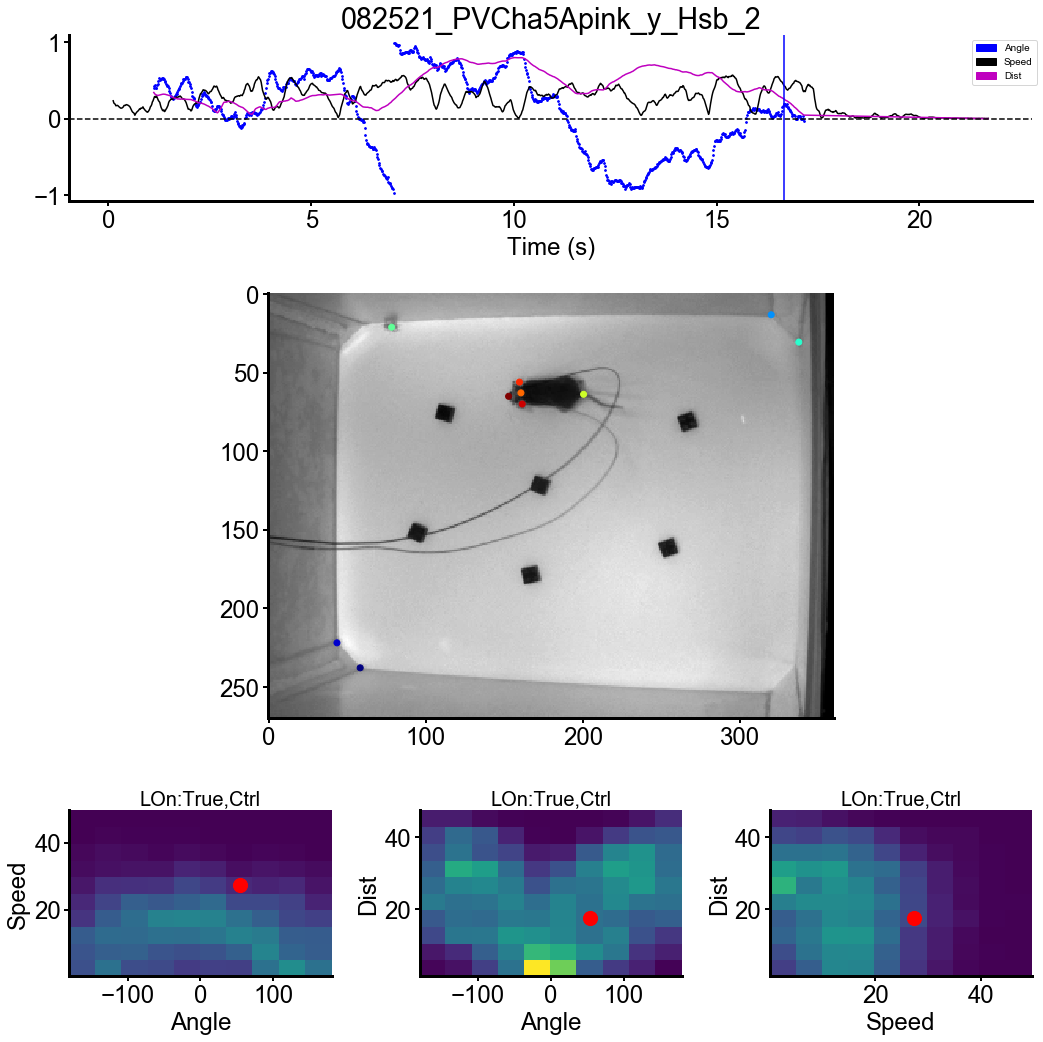

In [298]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
t = 1000
fig2 = plt.figure(constrained_layout=False, figsize=(15,15))
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
axs1 = fig2.add_subplot(spec2[0, :]) 
axs2 = fig2.add_subplot(spec2[1:3, :])
axs3 = np.array([fig2.add_subplot(spec2[3, n]) for n in range(3)])
# Plotting Angle, Speed, Dist
p1 = axs1.scatter(tvid,ang_norm, 3, c='b',)
p2 = axs1.plot(tvid,spd_norm, c='k')
p3 = axs1.plot(tvid,dist_norm, c='m')
axs1.legend(handles=[blue_patch,black_patch,m_patch],labels=['Angle','Speed','Dist'],loc='upper right',bbox_to_anchor=(1.01, 1), fontsize=10)
axs1.axhline(y=0,c='k',linestyle='--')
axs1.set_title(fname.split('/')[-1][:-9])
axs1.axvline(x=tvid[t],c='b',linestyle='-')
axs1.set_xlabel('Time (s)')

# Image Frame and DLC Tracking
axs2.imshow(Vid[t],cmap='gray')
axs2.scatter(pts.iloc[t,::3]*downsamp,pts.iloc[t,1::3]*downsamp,c=np.arange(npts-1,-1,-1),cmap=cmap)

# 2d hist of Angle, Speed, Dist.
for n in range(perms.shape[0]):
    clim = (hist_data_all[:,:,:,:,n,en].min(),hist_data_all[:,:,:,:,n,en].max())
    hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==LaserOn) & (df['Environment']==Env)].reset_index()
    h_on, xbins_on, ybins_on, im_on, = axs3[n].hist2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=nbins, density=True,vmin=clim[0],vmax=clim[1])
    axs3[n].set_xlabel(metrics[perms[n,0]])
    axs3[n].set_ylabel(metrics[perms[n,1]])
    axs3[n].set_title('LOn:{},{}'.format(LaserOn,df_trial['Exp_Ctrl']),fontsize=20)
    if np.isnan(asd[perms[n],t]).any() != True:
        xpt = xbins_on[np.digitize(asd[perms[n,0],t],xbins_on)]+np.mean(np.diff(xbins_on))/2
        ypt = ybins_on[np.digitize(asd[perms[n,1],t],ybins_on)]+np.mean(np.diff(ybins_on))/2
        axs3[n].scatter(xpt, ypt, 200,'r')
plt.tight_layout()


# plt.show()
# anim = FuncAnimation(fig2, animate, tqdm(range(0,len(mx))), init_func=init, blit=True,fargs=(lab,ms,cr)) 
# writervideo = FFMpegWriter(fps=60) 

# anim.save(FigPath /('_'.join([date,ani,str(trial),'K{}'.format(K)])+'.mp4'),writer=writervideo)


Load in dlc points add color, make sure video is synced with other traces. 

In [295]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Angle')
black_patch = mpatches.Patch(color='black', label='Speed')
m_patch = mpatches.Patch(color='m', label='Dist')
# clr = discrete_cmap(len(pts.iloc[0,::3]),'jet')
cmap = mpl.cm.get_cmap('jet', npts)    # 16 discrete colors


  0%|          | 0/1303 [00:00<?, ?it/s]

Animation:  2343.8235063552856


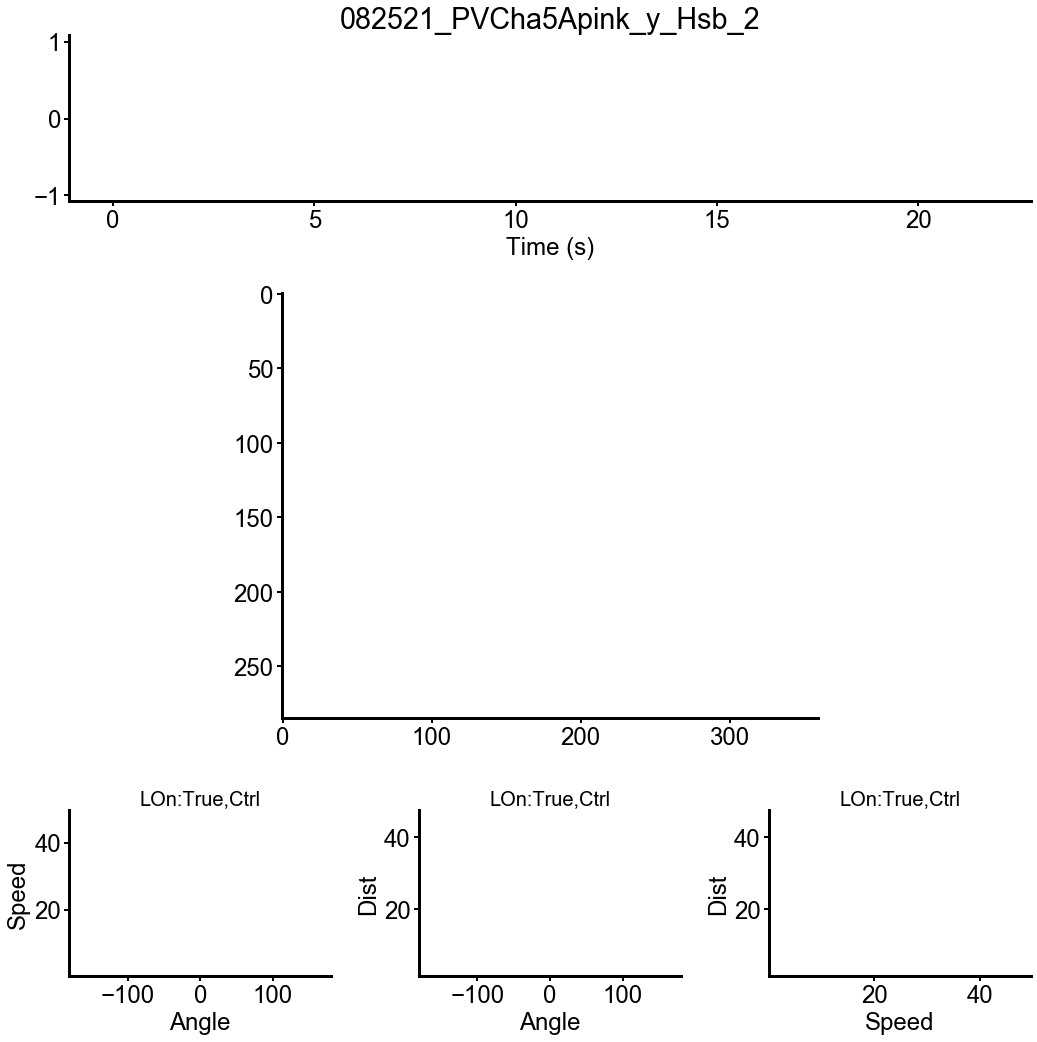

In [256]:
start = time.time()
nbins=10
xbins_on_all = np.zeros((perms.shape[0],nbins+1))
ybins_on_all = np.zeros((perms.shape[0],nbins+1))
fig2 = plt.figure(constrained_layout=False, figsize=(15,15))
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
axs1 = fig2.add_subplot(spec2[0, :]) 
axs2 = fig2.add_subplot(spec2[1:3, :])
axs3 = np.array([fig2.add_subplot(spec2[3, n]) for n in range(3)])
camera = Camera(fig2)
for t in tqdm(np.arange(tvid.shape[0])):
    p1 = axs1.plot(tvid,ang_norm, c='b.')
    p2 = axs1.plot(tvid,spd_norm, c='k')
    p3 = axs1.plot(tvid,dist_norm, c='m')
    axs1.legend(handles=[blue_patch,black_patch,m_patch],labels=['Angle','Speed','Dist'],loc='upper right',bbox_to_anchor=(1.01, 1), fontsize=10)
    axs1.axhline(y=0,c='k',linestyle='--')
    axs1.set_title(fname.split('/')[-1][:-9])
    axs1.axvline(x=tvid[t],c='b',linestyle='-')
    axs1.set_xlabel('Time (s)')

    axs2.imshow(Vid[t],cmap='gray')
    axs2.scatter(pts.iloc[t,::3]*downsamp,pts.iloc[t,1::3]*downsamp,c=np.arange(len(pts.iloc[0,::3])),cmap=clr)
    for n in range(perms.shape[0]):
        clim = (hist_data_all[:,:,:,:,n,en].min(),hist_data_all[:,:,:,:,n,en].max())
        hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==LaserOn) & (df['Environment']==Env)].reset_index()
        h_on, xbins_on, ybins_on, im_on, = axs3[n].hist2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=nbins, density=True,vmin=clim[0],vmax=clim[1])
        axs3[n].set_xlabel(metrics[perms[n,0]])
        axs3[n].set_ylabel(metrics[perms[n,1]])
        axs3[n].set_title('LOn:{},{}'.format(LaserOn,df_trial['Exp_Ctrl']),fontsize=20)
        if np.isnan(asd[perms[n],t]).any() != True:
            xpt = xbins_on[np.digitize(asd[perms[n,0],t],xbins_on)]+np.mean(np.diff(xbins_on))/2
            ypt = ybins_on[np.digitize(asd[perms[n,1],t],ybins_on)]+np.mean(np.diff(ybins_on))/2
            axs3[n].scatter(xpt, ypt, 200,'r')
    plt.tight_layout()
    camera.snap()
animation = camera.animate(interval=(1/fps)*1000)
animation.save(FigPath / aniname)
print('Animation: ', time.time()-start)


In [216]:
animation = camera.animate(interval=(1/fps)*1000)
animation.save(FigPath / aniname)


(1303, 270, 360)

In [88]:
bin_midsx = np.array([(xbins_on[i]+xbins_on[i+1])/2 for i in range(len(xbins_on)-1)])
bin_midsy = np.array([(ybins_on[i]+ybins_on[i+1])/2 for i in range(len(ybins_on)-1)])


### Umap Testing

In [42]:
import umap
import seaborn as sns


2021-10-12 13:30:48.218898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [96]:
inds = sorted(np.random.choice(np.arange(0,X.shape[0]),50000))
reducer = umap.UMAP()
embedding = reducer.fit_transform(X[inds,:])
embedding.shape

(50000, 2)

In [ ]:
embedding = reducer.transform(X)

In [11]:
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Data')
# df_all2 = df_all.reset_index()
# df_all2.to_feather(SavePath/'df_all.feather')

In [16]:
# df['embedding0'] = embedding[:,0]
# df['embedding1'] = embedding[:,1]
# df2 = df.reset_index()
# df2.to_feather(SavePath/'df.feather')
path = os.path.expanduser('~/Research/PreyCapture/ModelFits/K4')
df = pd.read_feather(path +'/df.feather')
df = df.set_index(['experiment_date','animal_name','Trial'])


In [20]:
embedding = df[['embedding0','embedding1']].to_numpy()

In [53]:
embedding.shape[0]/3600

572.7186111111112

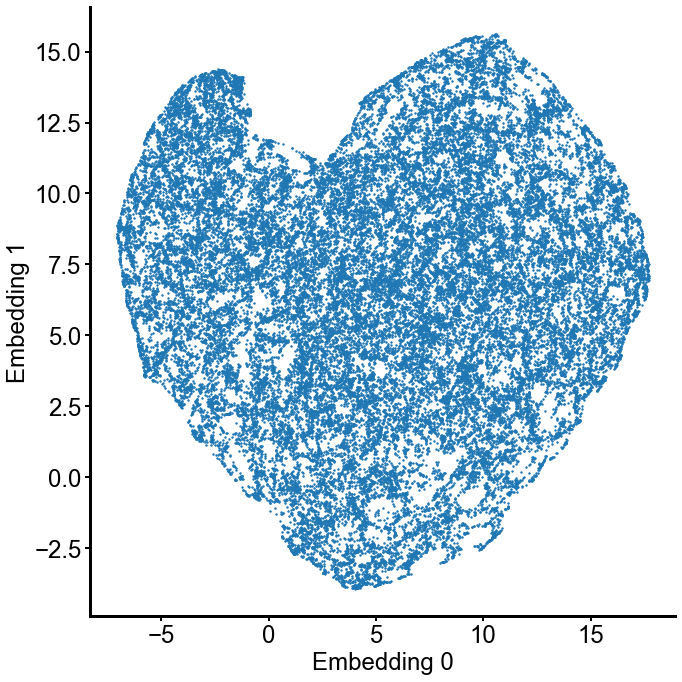

In [99]:
# inds = sorted(np.random.choice(np.arange(0,embedding.shape[0]),1000))
fig,ax = plt.subplots(figsize=(10,10))
# ax.scatter(embedding[inds,0],embedding[inds,1])
ax.scatter(embedding[:,0],embedding[:,1],s=2)
ax.set_xlabel('Embedding 0')
ax.set_ylabel('Embedding 1')
plt.tight_layout()

In [57]:
##### Group shuffle #####
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=1)
groups = df['GroupNum'].values
for train_idx, test_idx in gss.split(np.arange(len(groups)), groups=groups):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [      0       1       2 ... 2061784 2061785 2061786] TEST: [  19493   19494   19495 ... 2051489 2051490 2051491]


In [60]:
X_train =X[train_idx]
X_test = X[test_idx]
df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

In [61]:
X_train.shape, X_test.shape

((1407912, 3), (653875, 3))

In [162]:
##### Modified from D. Wyrick 090621 by Elliott Abe #####
def params_to_dict(params):
    """
    Intended usage: 
    When setting up model, define
        model_type = dict(HMM_INPUTS=False, HMM_RECURRENCE=False, R_INPUTS=False, ROBUST=True)
    etc, then run 
    par_dict = params_to_dict(arhmm.params, model_type)
    and save par_dict to file using io_dict_to_hdf5.py.
    """
    init = {}
    init['P0'] = params[0][0]
    
    trans = {}
    trans['log_Ps'] = params[1][0]
    
    obs = {}    
    obs['As'] = params[2][0]
    obs['bs'] = params[2][1]
    obs['ABs'] = np.concatenate((obs['As'][:,:,None],obs['bs']),axis=-1)

    out = {}
    out['init_state_distn'] = init
    out['transitions'] = trans
    out['observations'] = obs  
    return out

def dict_to_params(par_dict):
    params = [[] for ii in range(3)]
    # Initial State parameters
    params[0].append(par_dict['init_state_distn']['P0'] )
    
    # Transition Parameters
    params[1].append( par_dict['transitions']['log_Ps'] )
    
    # Observation Parameters
    params[2].append( par_dict['observations']['As'] )
    params[2].append( par_dict['observations']['bs'] )  
                         
    return params

In [72]:
K=4
N_iters = 50
hmm = ssm.HMM(K, embedding.shape[-1], observations="gaussian")
hmm_lls = hmm.fit(X_train, method="em", num_iters=N_iters, init_method="kmeans")
FigPath_models = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/K{}'.format(K))
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'ModelFits/K{}'.format(K))
params_dict = params_to_dict(hmm.params)
# params = dict_to_params(params_dict)
ioh5.save((SavePath/'hmm_preycap_embedding_{}_Niter{:d}_K{:d}.h5'.format(datetime.today().strftime('%m%d%y'),N_iters,K)).as_posix(), params_dict)

  0%|          | 0/50 [00:00<?, ?it/s]

In [163]:
K=10
N_iters = 100
hmm = ssm.HMM(K, X.shape[-1], observations="gaussian")
hmm_lls = hmm.fit(X_train, method="em", num_iters=N_iters, init_method="kmeans")
FigPath_HMM = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/K{}'.format(K))
SavePath_HMM = check_path(Path('~/Research/PreyCapture/').expanduser(),'ModelFits/K{}'.format(K))
params_dict = params_to_dict(hmm.params)
# params = dict_to_params(params_dict)
ioh5.save((SavePath_HMM/'hmm_preycap_{}_Niter{:d}_K{:d}.h5'.format(datetime.today().strftime('%m%d%y'),N_iters,K)).as_posix(), params_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

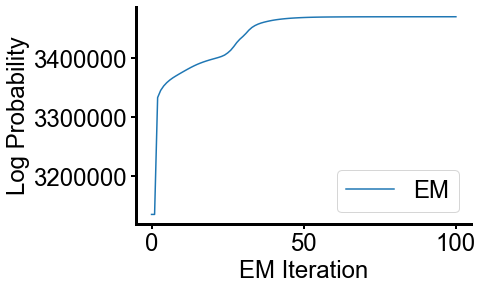

In [165]:
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [166]:
# Find a permutation of the states that best matches the true and inferred states
# most_likely_states = hmm.most_likely_states(X2)
hmm_states = hmm.most_likely_states(X)
df['hmm_states'] = hmm_states.copy()
Ez, Ej, ll = hmm.expected_states(X)

map_seq = np.argmax(Ez,axis=1)
max_prob = Ez[np.r_[0:Ez.shape[0]],map_seq]

trMasks = max_prob > .75
df.loc[~trMasks,'hmm_states'] = np.nan
# states_test = hmm.most_likely_states(X_test)

/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



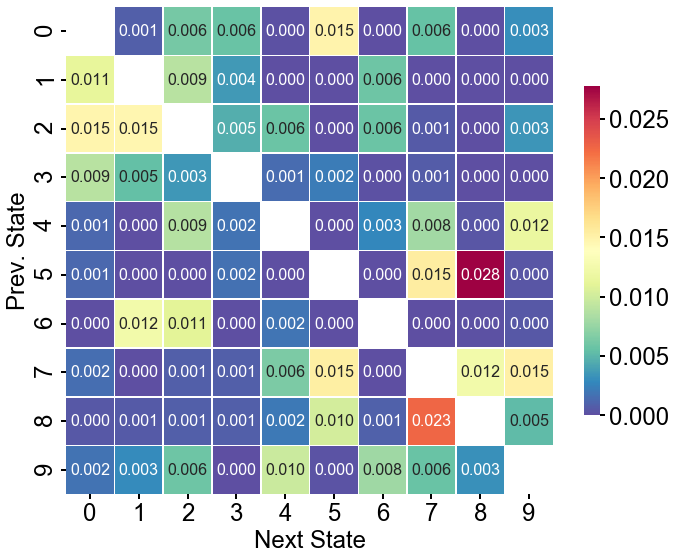

In [167]:
learned_transition_mat = hmm.transitions.transition_matrix
# vmin = np.min(np.hstack((TCM1b,TCM2b)))
# vmax = .25#np.max(np.hstack((TCM1b,TCM2b)))
diag_mask = np.ones((K,K),dtype=bool)
diag_mask[np.diag_indices(K)] = False
fig, ax = plt.subplots(1,figsize=(10,10))
sns.heatmap(learned_transition_mat,ax=ax,mask=~diag_mask,annot=True,annot_kws={'fontsize':16},square=True,cmap='Spectral_r',cbar_kws={'shrink':0.5},fmt=".03f", linewidths=.5)
# ax.set_title('Binocular')
ax.set_xlabel('Next State')
ax.set_ylabel('Prev. State')
ax.set_xticklabels(np.arange(0,K))
ax.set_yticklabels(np.arange(0,K))
plt.tight_layout()

In [168]:
end_state = []
for ind, row in tqdm(df_meta[df_meta['Capture']==True].iterrows(),total=df_meta[df_meta['Capture']==True].shape[0]):
    num, count = mode(df.xs((row['experiment_date'],row['animal_name'],row['Trial']),level=(0,1,2))['hmm_states'].iloc[-30:])
#     num, count = mode(df.loc[(df['experiment_date']==row['experiment_date'])&(df['animal_name']==row['animal_name'])&(df['Trial']==row['Trial'])]['hmm_states'].iloc[-30:])
    end_state.append(num)

end_state = np.stack(end_state)


  0%|          | 0/1100 [00:00<?, ?it/s]

8

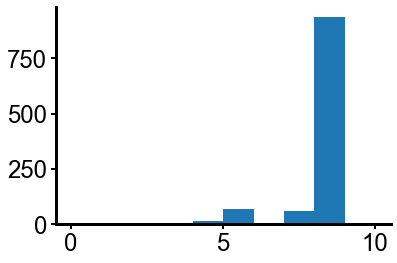

In [169]:
(count, bins,hist) = plt.hist(end_state,bins=np.arange(0,K+1))
approach_state = bins[np.argmax(count)]
approach_state

In [170]:
df_cap[df_cap['Exp_Ctrl']=='Ctrl'].head()

,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture,dist_at_approach,Capture,Environment,Exp_Ctrl,LaserOffInd,LaserOffT,LaserOn,LaserOnInd,LaserOnT,Trial,animal_name,experiment_date,dist_at_fapproach,Cap_dur_laser
26,21.716667,17.150000,2.533952,0.230238,0.200000,1.000000,"[7.008341027272556, 11.350892374989128, 25.512...",True,Hsb,Ctrl,1294,21.573107,True,23,0.384013,2,PVCha5Apink,082521,NaN,True
28,20.216667,13.966667,3.967552,0.395713,0.625000,0.200000,"[32.385445718279165, 19.84950492381208, 6.9694...",True,Hsb,Ctrl,1040,17.338508,True,26,0.433049,4,PVCha5Apink,082521,NaN,True
29,64.516667,64.500000,2.032218,0.387497,0.200000,0.200000,"[12.94273833452134, 6.357687662259476, 24.2827...",True,Hsb,Ctrl,-999,NaN,False,-999,NaN,5,PVCha5Apink,082521,NaN,False
35,45.050000,42.033333,1.333888,0.443951,0.150000,0.333333,"[23.766939165708934, 23.493917046014214, 9.345...",True,Hsb,Ctrl,2175,36.261977,True,7,0.117747,1,PV154pink,082521,NaN,False
37,32.266667,29.566667,0.200025,0.526860,0.294118,0.200000,"[24.485703702109898, 33.552566535956245, 20.11...",True,Hsb,Ctrl,-999,NaN,False,-999,NaN,3,PV154pink,082521,NaN,False


In [29]:
df_cap = df_meta[df_meta['Capture']==True]
# df_cap = df_meta[(df_meta['LaserOn']==True)]

In [51]:
df.head()

Angle     Speed       Dist   Mouse_x  \
experiment_date animal_name Trial                                             
082521          PVCha2black 1     -22.951467  0.116312  20.761324  7.571586   
                            1     -22.393889  0.039550  18.985130  7.554922   
                            1      -9.550244  0.182478  12.951043  7.573205   
                            1      -2.750227  0.119839  11.486301  7.566575   
                            1       7.437414  0.048882  10.352051  7.567440   

                                     Mouse_y  Cricket_x  Cricket_y         t  \
experiment_date animal_name Trial                                              
082521          PVCha2black 1      26.037581   6.394965   5.309625  0.468148   
                            1      26.072119   6.899012   7.098323  0.483725   
                            1      26.051174   9.967942  13.323458  0.534656   
                            1      26.042998  11.072731  15.104900  0.551655   
                            1      26.042762  12.297671  16.834621  0.567540   

                                   GroupNum  Angle_norm  Speed_norm  \
experiment_date animal_name Trial                                     
082521          PVCha2black 1             0   -0.127508    0.002326   
                            1             0   -0.124410    0.000791   
                            1             0   -0.053057    0.003650   
                            1             0   -0.015279    0.002397   
                            1             0    0.041319    0.000978   

                                   Dist_norm  LaserOn  ExpAni  hmm_states  \
experiment_date animal_name Trial                                           
082521          PVCha2black 1       0.415226     True    True         1.0   
                            1       0.379703     True    True         1.0   
                            1       0.259021     True    True         1.0   
                            1       0.229726     True    True         1.0   
                            1       0.207041     True    True         1.0   

                                   embedding0  embedding1  
experiment_date animal_name Trial                          
082521          PVCha2black 1        5.603161   18.909500  
                            1        5.560886   18.473978  
                            1        8.338497   17.678684  
                            1        9.066836   17.524427  
                            1        9.458863   17.145071

Group by control, camo, camo+blocks
laser on vs off

In [35]:
n= 26#np.random.randint(0,len(df_cap))
trial = df_cap['Trial'].iloc[n]
date = df_cap['experiment_date'].iloc[n]
ani = df_cap['animal_name'].iloc[n]
lon = df_cap['LaserOnInd'].iloc[n]
loff = df_cap['LaserOffInd'].iloc[n]
print('{}, {}, {}, {}'.format(n,date,ani,trial))
mx = df.xs((date,ani,trial),level=(0,1,2))['Mouse_x'].values
my = df.xs((date,ani,trial),level=(0,1,2))['Mouse_y'].values
cx = df.xs((date,ani,trial),level=(0,1,2))['Cricket_x'].values
cy = df.xs((date,ani,trial),level=(0,1,2))['Cricket_y'].values
ang = df.xs((date,ani,trial),level=(0,1,2))['Angle_norm'].values
spd = df.xs((date,ani,trial),level=(0,1,2))['Speed_norm'].values
dist = df.xs((date,ani,trial),level=(0,1,2))['Dist_norm'].values
lab = df.xs((date,ani,trial),level=(0,1,2))['hmm_states'].values
t = df.xs((date,ani,trial),level=(0,1,2))['t'].values 
em0 =df.xs((date,ani,trial),level=(0,1,2))['embedding0'].values 
em1 =df.xs((date,ani,trial),level=(0,1,2))['embedding1'].values 
df_trial = df_meta[((df_meta['experiment_date']==date)&(df_meta['animal_name']==ani)&(df_meta['Trial']==trial))]
# csv2[(csv2['animal_name']==ani) & (csv2['experiment_date']==date) & (csv2['Trial']==trial)]
df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]

26, 082621, PVCha2black, 2


,animal_name,experiment_date,Trial,CaptureT,MovieT,LaserOnT,LaserOffT,LaserOn,Environment,Exp_Ctrl,Capture,Cap_dur_laser
46,PVCha2black,082621,2,9.3,13.733333,NaN,NaN,False,Wno,Exp,True,False


Historgrams, then 2d heat maps. Then Umap to view 2d

In [171]:
df.head()

Angle     Speed       Dist   Mouse_x  \
experiment_date animal_name Trial                                             
082521          PVCha2black 1     -22.951467  0.116312  20.761324  7.571586   
                            1     -22.393889  0.039550  18.985130  7.554922   
                            1      -9.550244  0.182478  12.951043  7.573205   
                            1      -2.750227  0.119839  11.486301  7.566575   
                            1       7.437414  0.048882  10.352051  7.567440   

                                     Mouse_y  Cricket_x  Cricket_y         t  \
experiment_date animal_name Trial                                              
082521          PVCha2black 1      26.037581   6.394965   5.309625  0.468148   
                            1      26.072119   6.899012   7.098323  0.483725   
                            1      26.051174   9.967942  13.323458  0.534656   
                            1      26.042998  11.072731  15.104900  0.551655   
                            1      26.042762  12.297671  16.834621  0.567540   

                                   GroupNum Environment  Angle_norm  \
experiment_date animal_name Trial                                     
082521          PVCha2black 1             0         Hsb   -0.127508   
                            1             0         Hsb   -0.124410   
                            1             0         Hsb   -0.053057   
                            1             0         Hsb   -0.015279   
                            1             0         Hsb    0.041319   

                                   Speed_norm  Dist_norm  LaserOn  ExpAni  \
experiment_date animal_name Trial                                           
082521          PVCha2black 1        0.002326   0.415226     True    True   
                            1        0.000791   0.379703     True    True   
                            1        0.003650   0.259021     True    True   
                            1        0.002397   0.229726     True    True   
                            1        0.000978   0.207041     True    True   

                                   hmm_states  
experiment_date animal_name Trial              
082521          PVCha2black 1             3.0  
                            1             3.0  
                            1             3.0  
                            1             3.0  
                            1             3.0

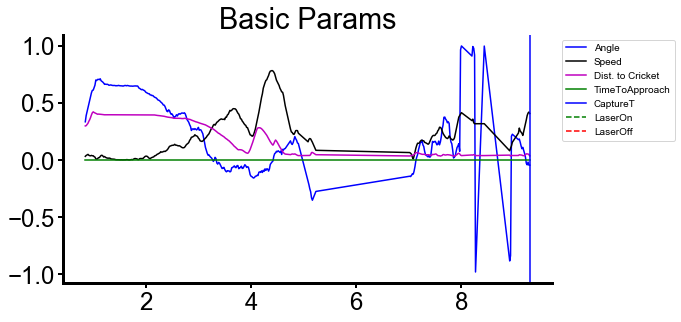

In [172]:
med_filt_win=15
approach  = ((np.abs(ang) < 30) & (spd > 5)).astype(int)
approach = signal.medfilt(approach, med_filt_win) # 31 is hardcoded half a second based on framerate; 15=.25*60 fps
approach = np.asarray(approach)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t,ang, c='b')
ax.plot(t,spd, c='k')
ax.plot(t,dist, c='m')
ax.plot(t,approach,c='g')
# ax.axvline(x=approach, c='g')
# ax.axvline(x=approach, c='r')
ax.set_title('Basic Params')
if df_trial['Capture'].iloc[0]==True:
    ax.axvline(x=df_trial['CaptureT'].values,c='b',linestyle='-')
ax.axvline(x=df_trial['LaserOnT'].values,c='g',linestyle='--')
ax.axvline(x=df_trial['LaserOffT'].values,c='r',linestyle='--')
ax.legend(['Angle', 'Speed', 'Dist. to Cricket', 'TimeToApproach', 'CaptureT','LaserOn','LaserOff'], bbox_to_anchor=(1.01, 1), fontsize=10)

plt.tight_layout()

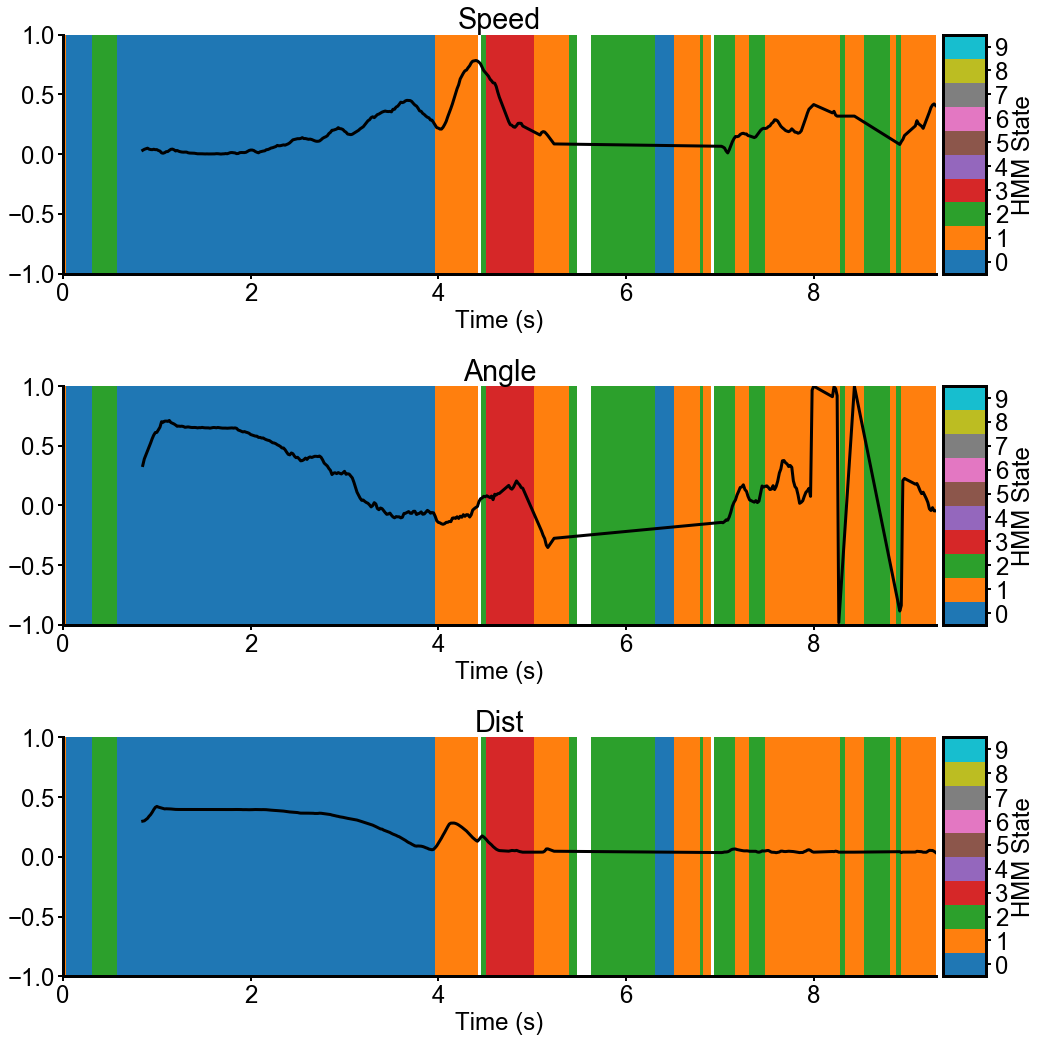

In [173]:
cmap_name = 'tab10' #'Accent'
cmap = mpl.cm.get_cmap(cmap_name, K)
LaserOnT = df_trial['LaserOnT'].values
LaserOffT = df_trial['LaserOffT'].values

fig, axs = plt.subplots(3,1,figsize=(15,15))
lim = 1 #1.05 * abs(spd).max()
img=axs[0].imshow(lab[None,:],aspect='auto',cmap=cmap,vmin=0,vmax=len(np.unique(lab))-1,extent=(0, np.max(t), -lim, lim))
axs[0].plot(t,spd,c='k',lw=3)
axs[0].axvline(x=LaserOnT,c='b',linestyle='--',lw=3)
axs[0].axvline(x=LaserOffT,c='r',linestyle='--',lw=3)
axs[0].set_title('Speed')
axs[0].set_xlabel('Time (s)')
axs[0].set_yticks(np.arange(-lim,lim+.5,.5))
cbar = add_colorbar(img)
img.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
cbar.set_label('HMM State')

lim = 1 #1.05 * abs(ang).max()
img=axs[1].imshow(lab[None,:],aspect='auto',cmap=cmap,vmin=0,vmax=len(np.unique(lab))-1,extent=(0, np.max(t), -lim, lim))
axs[1].plot(t,ang,c='k',lw=3)
axs[1].axvline(x=LaserOnT,c='b',linestyle='--',lw=3)
axs[1].axvline(x=LaserOffT,c='r',linestyle='--',lw=3)
axs[1].set_title('Angle')
axs[1].set_xlabel('Time (s)')
axs[1].set_yticks(np.arange(-lim,lim+.5,.5))
cbar = add_colorbar(img)
img.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
cbar.set_label('HMM State')

lim = 1 #1.05 * abs(dist).max()
img=axs[2].imshow(lab[None,:],aspect='auto',cmap=cmap,vmin=0,vmax=len(np.unique(lab))-1,extent=(0, np.max(t), -lim, lim))
axs[2].plot(t,dist,c='k',lw=3)
axs[2].axvline(x=LaserOnT,c='b',linestyle='--',lw=3)
axs[2].axvline(x=LaserOffT,c='r',linestyle='--',lw=3)
axs[2].set_title('Dist')
axs[2].set_xlabel('Time (s)')
axs[2].set_yticks(np.arange(-lim,lim+.5,.5))
cbar = add_colorbar(img)
img.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
cbar.set_label('HMM State')
plt.tight_layout()

# fig.savefig(FigPath/'HMMstateEx_{}.png'.format('_'.join([date,ani,str(trial),'K{}'.format(K)])))

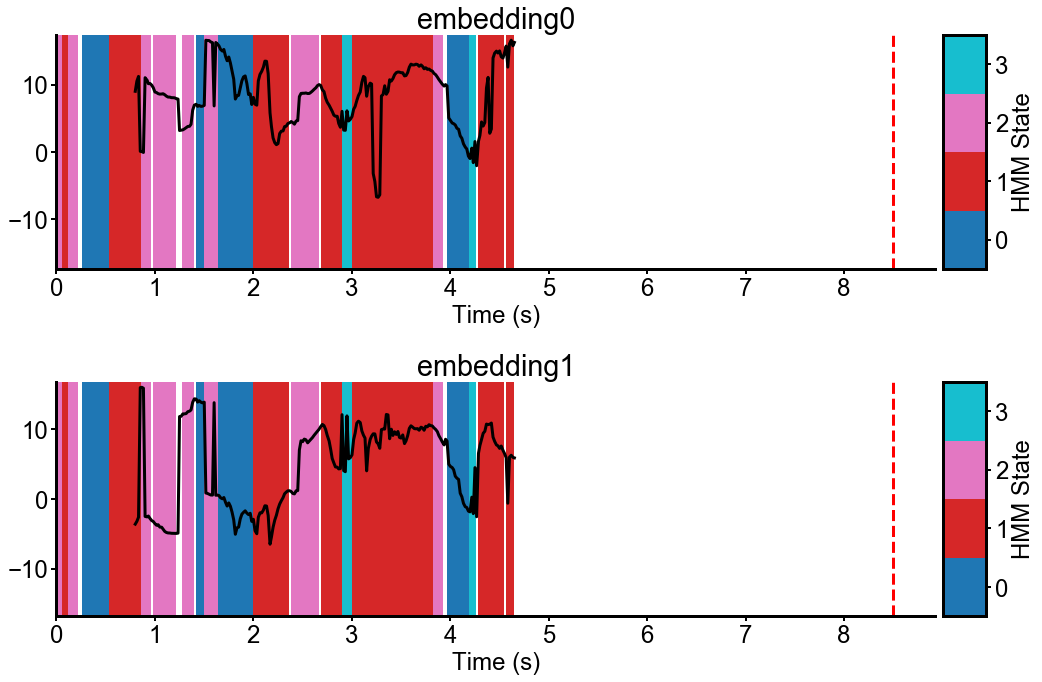

In [126]:
cmap_name = 'tab10' #'Accent'
cmap = mpl.cm.get_cmap(cmap_name, K)
LaserOnT = df_trial['LaserOnT'].values
LaserOffT = df_trial['LaserOffT'].values

fig, axs = plt.subplots(2,1,figsize=(15,10))
lim =1.05 * abs(em0).max()
img=axs[0].imshow(lab[None,:],aspect='auto',cmap=cmap,vmin=0,vmax=len(np.unique(lab))-1,extent=(0, np.max(t), -lim, lim))
axs[0].plot(t,em0,c='k',lw=3)
axs[0].axvline(x=LaserOnT,c='b',linestyle='--',lw=3)
axs[0].axvline(x=LaserOffT,c='r',linestyle='--',lw=3)
axs[0].set_title('embedding0')
axs[0].set_xlabel('Time (s)')
# axs[0].set_yticks(np.arange(-lim,lim+.5,.5))
cbar = add_colorbar(img)
img.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
cbar.set_label('HMM State')

lim = 1.05 * abs(em1).max()
img=axs[1].imshow(lab[None,:],aspect='auto',cmap=cmap,vmin=0,vmax=len(np.unique(lab))-1,extent=(0, np.max(t), -lim, lim))
axs[1].plot(t,em1,c='k',lw=3)
axs[1].axvline(x=LaserOnT,c='b',linestyle='--',lw=3)
axs[1].axvline(x=LaserOffT,c='r',linestyle='--',lw=3)
axs[1].set_title('embedding1')
axs[1].set_xlabel('Time (s)')
# axs[1].set_yticks(np.arange(-lim,lim+.5,.5))
cbar = add_colorbar(img)
img.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
cbar.set_label('HMM State')

plt.tight_layout()

In [70]:
labels = {
    'dimensions_'+str(i): f'{var}'
    for i, var in enumerate(['Angle','Speed','Dist'])
}

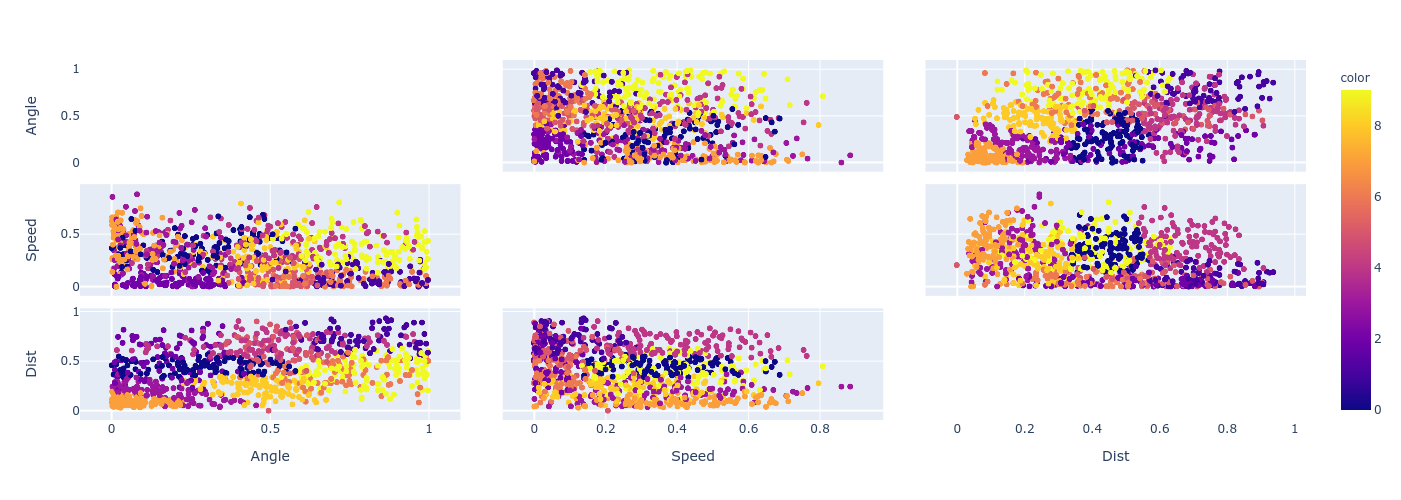

In [75]:
inds = sorted(np.random.choice(np.arange(0,X.shape[0]),1000))
fig = px.scatter_matrix(
    dimensions=X[inds,:].T,
    color=hmm_states[inds],
    labels=labels,
#     marker={'size':2}
)
fig.update_traces(diagonal_visible=False)
                  
fig.update_layout(width=700,
                  height=500,
                  )
fig.show()

In [ ]:
cscale = px.colors.qualitative.T10

fig = go.Figure(data=[go.Scatter3d(x=X[::10,0], y=X[::10,1], z=X[::10,2],
                                   mode='markers',
                                   marker=dict(
                                                size=3,
                                                color=hmm_states[::10],
                                                colorbar=dict(title='HMM State'),
                                                colorscale=cscale,   # choose a colorscale
                                                opacity=0.8),
                                   
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='HMM State'),
                  scene= dict(
                  xaxis_title='Angle',
                  yaxis_title='Speed',
                  zaxis_title='Dist'),
                  width=700,
                  height=500,
                  )
fig.show()

In [85]:
df['hmm_states'].head()

experiment_date  animal_name  Trial
082521           PVCha2black  1        2.0
                              1        2.0
                              1        2.0
                              1        2.0
                              1        NaN
Name: hmm_states, dtype: float64

In [86]:
df.head()

Angle     Speed       Dist   Mouse_x  \
experiment_date animal_name Trial                                             
082521          PVCha2black 1     -22.951467  0.116312  20.761324  7.571586   
                            1     -22.393889  0.039550  18.985130  7.554922   
                            1      -9.550244  0.182478  12.951043  7.573205   
                            1      -2.750227  0.119839  11.486301  7.566575   
                            1       7.437414  0.048882  10.352051  7.567440   

                                     Mouse_y  Cricket_x  Cricket_y         t  \
experiment_date animal_name Trial                                              
082521          PVCha2black 1      26.037581   6.394965   5.309625  0.468148   
                            1      26.072119   6.899012   7.098323  0.483725   
                            1      26.051174   9.967942  13.323458  0.534656   
                            1      26.042998  11.072731  15.104900  0.551655   
                            1      26.042762  12.297671  16.834621  0.567540   

                                   GroupNum  Angle_norm  Speed_norm  \
experiment_date animal_name Trial                                     
082521          PVCha2black 1             0   -0.127508    0.002326   
                            1             0   -0.124410    0.000791   
                            1             0   -0.053057    0.003650   
                            1             0   -0.015279    0.002397   
                            1             0    0.041319    0.000978   

                                   Dist_norm  LaserOn  ExpAni  hmm_states  
experiment_date animal_name Trial                                          
082521          PVCha2black 1       0.415226    False    True         2.0  
                            1       0.379703    False    True         2.0  
                            1       0.259021    False    True         2.0  
                            1       0.229726    False    True         2.0  
                            1       0.207041    False    True         NaN

In [87]:
df2 = df[['hmm_states','LaserOn','ExpAni']]
df2['hmm_states2'] = df['hmm_states'].copy()

/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [88]:
df_states.xs(True,level=2)#/df_states.xs(True,level=2).groupby(['LaserOn']).sum()

NameError: name 'df_states' is not defined

In [48]:
df_states.xs(False,level=2)#/df_states.xs(False,level=2).groupby(['LaserOn']).sum() 

hmm_states2
LaserOn hmm_states             
False   0.0               19101
        1.0               22475
        2.0               25801
        3.0               20424
        4.0                9354
        5.0               21627
True    0.0               16990
        1.0               17969
        2.0               25446
        3.0               20014
        4.0               10373
        5.0               20470

In [91]:
df_states = df2.groupby(['ExpAni','hmm_states','LaserOn']).count()
# df_states.xs(False,level=0)/df_states.xs(False,level=0).sum()
# df_states.xs(True,level=0)/df_states.xs(True,level=0).sum()
df_states

hmm_states2
ExpAni hmm_states LaserOn             
False  0.0        False          65770
                  True            1428
       1.0        False          54216
                  True            1189
       2.0        False          46651
                  True            1702
       3.0        False          77145
                  True            2175
       4.0        False          55275
                  True            2833
       5.0        False          67388
                  True            1954
True   0.0        False         174421
                  True            6781
       1.0        False         188162
                  True           10909
       2.0        False         178165
                  True            5325
       3.0        False         182847
                  True            7546
       4.0        False         191717
                  True           10309
       5.0        False         183147
                  True            6129

## Animations/Videos

In [318]:
FigPath = check_path(Path('~/Research/PreyCapture/').expanduser(),'Figures/K{}'.format(K))
SavePath = check_path(Path('~/Research/PreyCapture/').expanduser(),'ModelFits/K{}'.format(K))

In [319]:
def init():
    ms = ax.scatter([],[])
    cr = ax.scatter([],[],c='r')
    ax.set_xlim([0,50])
    ax.set_ylim([0,40])
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    return ms,cr

def animate(i, lab, ms,cr):
    if i < dt:
        ms.set_offsets(np.array([mx[:i],my[:i]]).T)
        ms.set_array(lab[:i])
        cr.set_offsets(np.array([cx[:i],cy[:i]]).T)
    else:
        ms.set_offsets(np.array([mx[i-dt:i],my[i-dt:i]]).T)
        ms.set_array(lab[i-dt:i])
        cr.set_offsets(np.array([cx[i-dt:i],cy[i-dt:i]]).T)
        plt.draw()
    return ms,cr

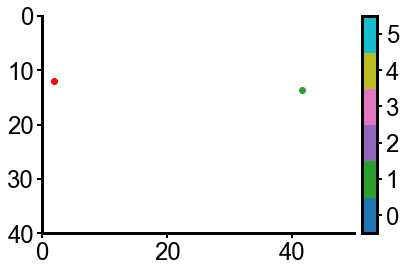

  0%|          | 0/1770 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

In [342]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
dt = 20
fig, ax = plt.subplots() # creating my fig
ms = ax.scatter(mx[:1],my[:1],c=lab[:1],cmap=cmap)
cr = ax.scatter(cx[:1],cy[:1],c='r')
ax.set_xlim([0,50])
ax.set_ylim([0,40])
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
cbar=add_colorbar(ms)
ms.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
plt.show()
anim = FuncAnimation(fig, animate, tqdm(range(0,len(mx))), init_func=init, blit=True,fargs=(lab,ms,cr)) 
writervideo = FFMpegWriter(fps=60) 

anim.save(FigPath /('_'.join([date,ani,str(trial),'K{}'.format(K)])+'.mp4'),writer=writervideo)


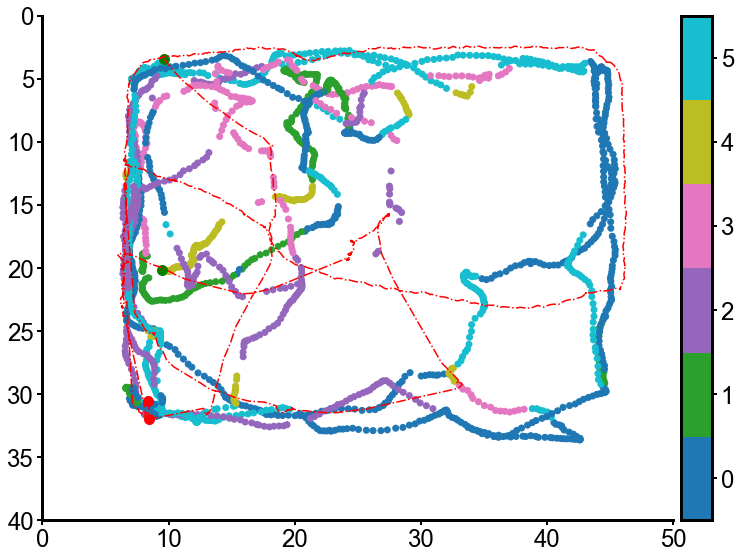

In [56]:
fig, ax = plt.subplots(figsize=(12, 10))
ms = ax.scatter(mx,my,c=lab,cmap=cmap)
ax.scatter(mx[0],my[0],c='g',s=100)
ax.scatter(cx[0],cy[0],c='g',s=100)
ax.scatter(mx[-1],my[-1],c='r',s=100)
ax.scatter(cx[-1],cy[-1],c='r',s=100)
ax.plot(cx,cy,'r-.')
ax.set_xlim([0,50])
ax.set_ylim([0,40])
cbar = add_colorbar(ms)
ms.set_clim([0,K])
cbar.set_ticks(np.linspace(cbar.vmin+.5,cbar.vmax-.5,K))
cbar.set_ticklabels(np.arange(K))
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_aspect('equal', 'box')

## Combining States

In [541]:
def merge_two_states(hmm, s1, s2, datas, observations="gaussian"):
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
        
    K = hmm.K
    D = hmm.D
    assert K >= 2
    assert s1 < K
    assert s2 < K
    assert s1 != s2
    datas = datas if isinstance(datas, list) else [datas]
    inputs, masks, tags = [None], [None], [None]
    expectations = [hmm.expected_states(data, input, mask, tag)
                            for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    
    # Merge expectations for 2 states
    expectations_new = []
    for (Ez, Ezz, py) in expectations:
        T_curr = Ez.shape[0]
        
        # Put merged expectations in first column
        Ez_new = collapse_and_sum_2d(Ez, s1, s2, axis=1)
        
        # Now merge Ezz
        # Ezz will have shape 1, K, K
        # so we get rid of the first dimension then add it back.
        Ezz_new = collapse_and_sum_2d(Ezz[0], s1, s2, axis=0)
        Ezz_new = collapse_and_sum_2d(Ezz_new, s1, s2, axis=1)
        Ezz_new = Ezz_new[None, :, :]
        
        expectations_new.append((Ez_new, Ezz_new, py))
    
    # Perform M-Step to get params for new hmm
    new_hmm = ssm.HMM(K-1, D, observations=observations)
    new_hmm.init_state_distn.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.transitions.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.observations.m_step(expectations_new, datas, inputs, masks, tags)
    
    # Evaluate log_likelihood
    expectations = [new_hmm.expected_states(data, input, mask, tag)
                    for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    new_ll = new_hmm.log_prior() + sum([ll for (_, _, ll) in expectations])
    return new_ll, new_hmm
        
def make_similarity_matrix(hmm, data):
    num_states = hmm.K
    init_ll = hmm.log_probability(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm, s1, s2, data)
            similarity[s1, s2] = merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
            
    return similarity, merged_hmms

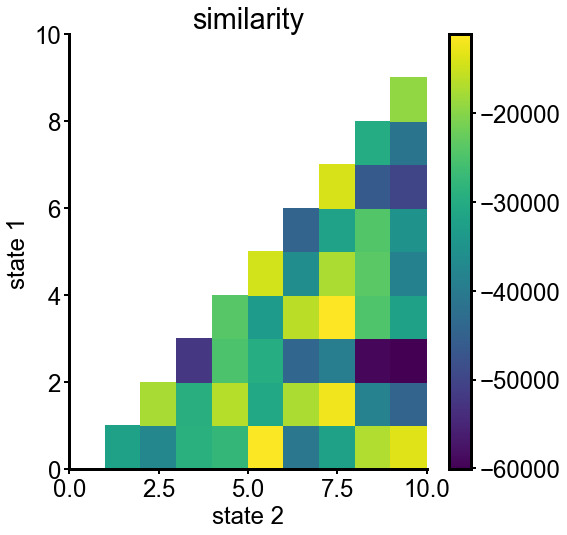

In [545]:
# similarity, new_hmms = make_similarity_matrix(hmm,X_test)
plt.figure(figsize=(8,8))
im = plt.pcolormesh(similarity)
plt.ylabel("state 1")
plt.xlabel("state 2")
plt.title("similarity")
plt.colorbar()

In [87]:
def hierarchical_cluster(hmm, data, plot=True):
    num_states = hmm.K
    linkage = [None]
    likelihood_drops = [0]
    hmms = [hmm]
    
#     if plot:
#         plot_hmm(hmm, data)
    
    for i in range(num_states - 1):
        similarity, merged_hmms = make_similarity_matrix(hmms[-1], data)
        
        # Find the most similar states
        s1, s2 = np.where(similarity == np.nanmax(similarity))
        s1, s2 = s1[0], s2[0]
        linkage.append((s1, s2))
        likelihood_drops.append(similarity[s1, s2])
        hmms.append(merged_hmms[s1, s2])
        print("merging ", s1, "and", s2)
        
        if plot:
            plt.figure()
            im = plt.imshow(similarity)
            plt.ylabel("state 1")
            plt.xlabel("state 2")
            plt.title("similarity")
            plt.colorbar()
            
#             plt.figure()
#             plot_hmm(hmms[-1], data)
    
    return linkage, likelihood_drops, hmms

merging  1 and 2
merging  2 and 3
merging  0 and 6
merging  1 and 5
merging  3 and 4
merging  0 and 4
merging  0 and 2
merging  1 and 2
merging  0 and 1


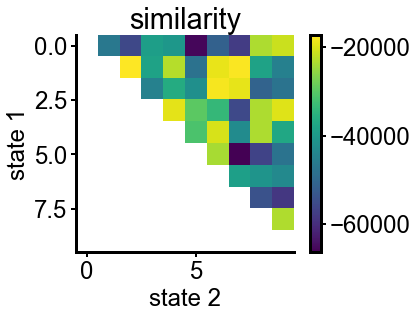

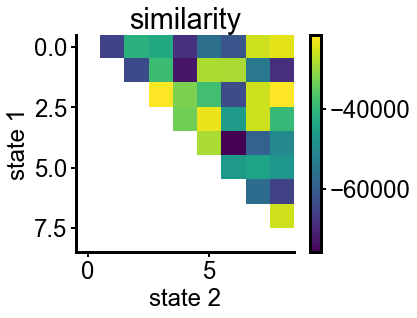

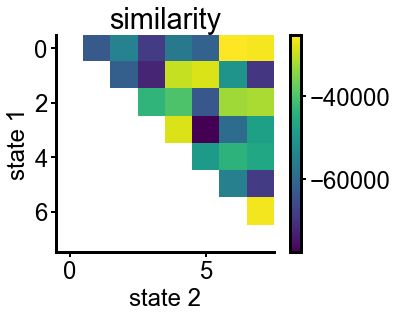

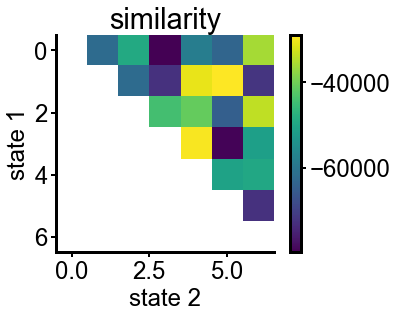

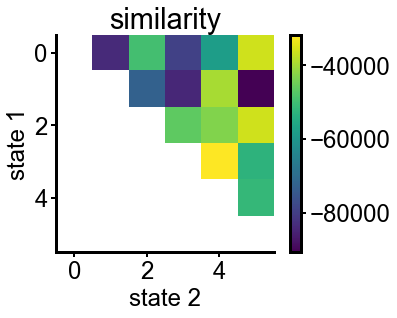

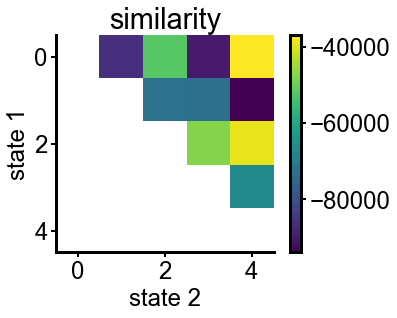

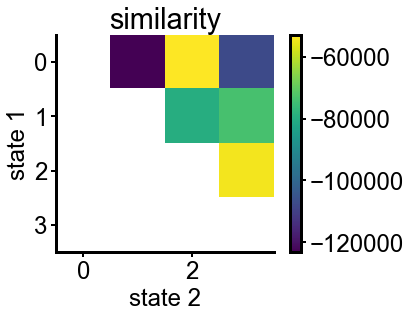

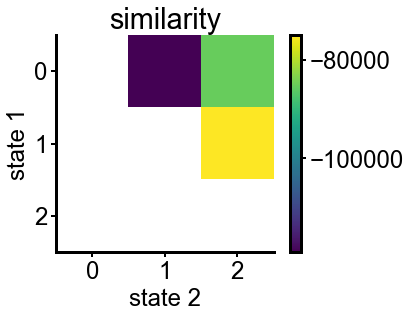

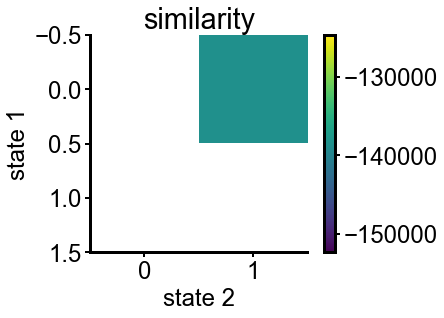

In [103]:
linkage, likelihood_drops, hmms = hierarchical_cluster(hmm, X_test)

In [91]:
import numpy.random as npr

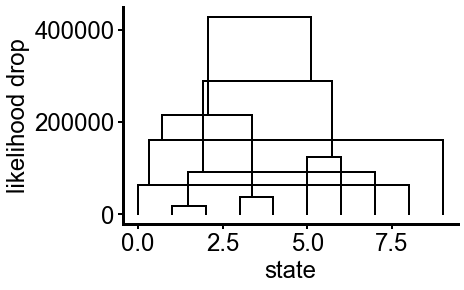

In [104]:
def dendrogram(num_states, linkage, likelihood_drops):
    plt.figure()
    
    def _plot_level(s1, s2, likelihood_drop, xs, offset):
        new_offset = offset - likelihood_drop
        for x in xs:
            plt.plot([x, x], [offset, new_offset], '-k', lw=2)
        plt.plot([xs[s1], xs[s2]], [new_offset, new_offset], '-k', lw=2)

        new_xs = xs.copy()
        new_xs[s1] = xs[s1] + (xs[s2] - xs[s1]) * npr.rand()
        new_xs = np.concatenate([new_xs[:s2], new_xs[s2+1:]])
        return new_xs, new_offset
    
    xs = np.arange(num_states, dtype=float)
    offset = 0
    for (s1, s2), drop in zip(linkage[1:], likelihood_drops[1:]):
        xs, offset = _plot_level(s1, s2, drop, xs, offset)
        
    plt.xlabel("state")
    plt.ylabel("likelihood drop")
        
dendrogram(hmm.K, linkage, likelihood_drops)

In [106]:
linkage

[None, (1, 2), (2, 3), (0, 6), (1, 5), (3, 4), (0, 4), (0, 2), (1, 2), (0, 1)]

### Lexical TCM

In [548]:
Ez, _, ll = hmm.expected_states(X_test)

map_seq = np.argmax(Ez,axis=1)
max_prob = Ez[np.r_[0:Ez.shape[0]],map_seq]

trMasks = max_prob > .75

In [553]:
max_prob.shape, trMasks.shape

((185052,), (185052,))

In [566]:
def get_transition_count_matrices(trMAPs, trMasks, K, normalize=False,lexical=True):
    ## Create 'Transition' count matrix for each trial from sparse MAP state sequence
    TCMs = np.zeros((K,K))
   
    #Loop over trials
#     for iTrial, (map_seq,mask) in enumerate(zip(trMAPs,trMasks)):
    #Apply threshold mask
    MAP = np.squeeze(map_seq).copy()
    MAP[~mask] = -1 #instead of np.nan

#     if all(~mask):
#         continue

    #Lets drop all of the non states for easy sorting
    #Shorted MAP state sequence
    sMAP = [int(s) for s in MAP if s != -1]

    #Count 'state transitons' and fill matrix
    prev_state = sMAP[0]
    for iT,state in enumerate(sMAP):
        #Create "Lexical transition matrix" 
        if lexical:
            if prev_state!=state:
                TCMs[prev_state,state]+=1
                prev_state = state
        #Or regular transition matrix
        else:
            TCMs[prev_state,state]+=1
            prev_state = state

    if normalize:
        TCMs = TCMs/np.sum(TCMs)
        
    return TCMs

In [567]:
TCMs = get_transition_count_matrices(max_prob,trMasks,K)

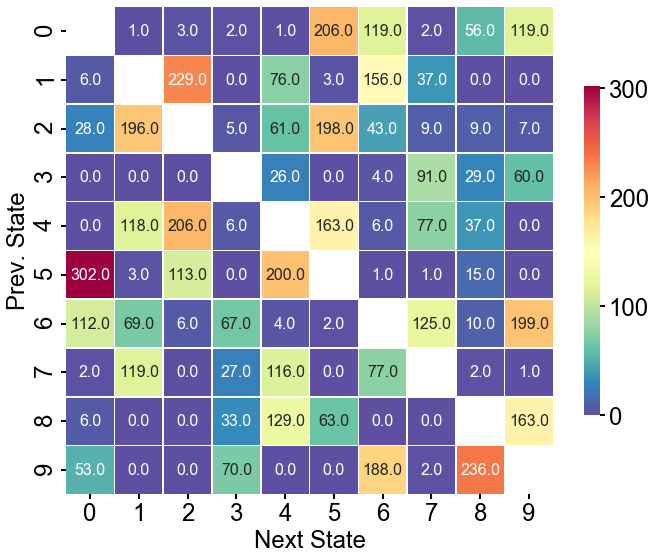

In [570]:
# vmin = np.min(np.hstack((TCM1b,TCM2b)))
# vmax = .25#np.max(np.hstack((TCM1b,TCM2b)))
diag_mask = np.ones((K,K),dtype=bool)
diag_mask[np.diag_indices(K)] = False
fig, ax = plt.subplots(1,figsize=(10,10))
sns.heatmap(TCMs,ax=ax,mask=~diag_mask,annot=True,annot_kws={'fontsize':16},square=True,cmap='Spectral_r',cbar_kws={'shrink':0.5},fmt=".01f", linewidths=.5)
ax.set_xlabel('Next State')
ax.set_ylabel('Prev. State')
ax.set_xticklabels(np.arange(0,K))
ax.set_yticklabels(np.arange(0,K))
plt.tight_layout()

## Other Testing

In [ ]:
HTML(anim.to_html5_video()) # displayin

In [ ]:
from celluloid import Camera # getting the camera
import time
from IPython.display import HTML # to show the animation in Jupyter

In [ ]:
cmap = mpl.cm.get_cmap(cmap_name, K)
# start = time.time()
dt = 10
fig, ax = plt.subplots() # creating my fig
camera = Camera(fig)# the camera gets the fig we'll plot
ms = ax.scatter(mx[:1],my[:1],c=lab[:1],cmap=cmap)
cr = ax.scatter(cx[:1],cy[:1],c='r')
ax.set_xlim([0,50])
ax.set_ylim([0,40])
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
for i in range(len(mx[::2])):
    if i < dt:
        im = ax.scatter(mx[:i],my[:i],c=lab[:i],cmap=cmap)
        ax.scatter(cx[:i],cy[:i],c='r')
    else:
        im = ax.scatter(mx[i-dt:i],my[i-dt:i],c=lab[i-dt:i],cmap=cmap)
        ax.scatter(cx[i-dt:i],cy[i-dt:i],c='r')
    camera.snap() # the camera takes a snapshot of the plot
animation = camera.animate(interval=20) # animation ready
writervideo = FFMpegWriter(fps=60) 
animation.save(FigPath /('_'.join([date,ani,str(trial),'K{}'.format(K)])+'.mp4'),writer=writervideo)
# HTML(animation.to_html5_video()) # displayin

In [ ]:
cscale = px.colors.qualitative.T10

fig = go.Figure(data=[go.Scatter3d(x=X[::10,0], y=X[::10,1], z=X[::10,2],
                                   mode='markers',
                                   marker=dict(
                                                size=3,
                                                color=hmm_states[::10],
                                                colorbar=dict(title='HMM State'),
                                                colorscale=cscale,   # choose a colorscale
                                                opacity=0.8),
                                   
                                   )])
fig.update_layout(autosize=False,
                  coloraxis_colorbar=dict(title='HMM State'),
                  scene= dict(
                  xaxis_title='Angle',
                  yaxis_title='Speed',
                  zaxis_title='Dist'),
                  width=700,
                  height=500,
                  )
fig.show()

# K Means Clustering

In [585]:
kclustering = KMeans(n_clusters=6)

labels = kclustering.fit_predict(X2)
df['labels'] = labels

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=X2[::100,0], y=X2[::100,1], z=X2[::100,2],
                                   mode='markers',
                                   marker=dict(
                                                size=5,
                                                color=labels[::100],
#                                                 colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   
                                   )])
fig.update_layout(autosize=False,
#                   coloraxis_colorbar=dict(title='Time (s)'),
                  scene= dict(
                  xaxis_title='Angle',
                  yaxis_title='Speed',
                  zaxis_title='Dist'),
                  width=500,
                  height=500,
                  )
fig.show()

In [630]:
trial = 5
date = '082521'
ani = 'PVCha2black'
mx = df.xs((date,ani,trial),level=(0,1,2))['Mouse_x'].values
my = df.xs((date,ani,trial),level=(0,1,2))['Mouse_y'].values
cx = df.xs((date,ani,trial),level=(0,1,2))['Cricket_x'].values
cy = df.xs((date,ani,trial),level=(0,1,2))['Cricket_y'].values
lab = df.xs((date,ani,trial),level=(0,1,2))['labels'].values 

In [972]:

# cmap = mpl.cm.viridis
# bounds = np.unique(lab)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap = mpl.cm.get_cmap(cmap_name,K)

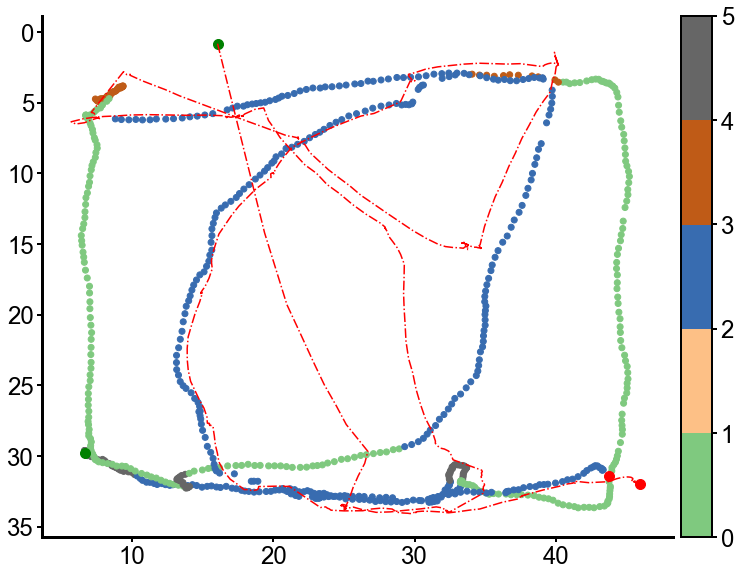

In [1118]:
fig, ax = plt.subplots(figsize=(12, 10))
# fig.subplots_adjust(bottom=0.5)

im = ax.scatter(mx,my,c=lab,cmap=cmap)
ax.scatter(mx[0],my[0],c='g',s=100)
ax.scatter(cx[0],cy[0],c='g',s=100)
ax.scatter(mx[-1],my[-1],c='r',s=100)
ax.scatter(cx[-1],cy[-1],c='r',s=100)
ax.plot(cx,cy,'r-.')
im.set_clim([0,K])
cbar = add_colorbar(im)

ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_aspect('equal', 'box')

Take total amount of time for light on and light off, and divide by # of captures in light on vs light off. Proxy for time to capture

Mean time in each state. Laser mice might have more time in stationary state. Cricket change in velocity/angles. 

laser on vs laser off in geneotype first 30s vs last 30s

# Renaming

In [10]:
import shutil
import os


anilist = os.listdir('/home/seuss/NewMonster/T/BinocOptoPreyCapture/092021/')

fpath = Path('/home/seuss/NewMonster/T/BinocOptoPreyCapture/092021/')

# # Move files
# for k in range(1,len(anilist)):
#     filelist=[f for f in fpath.rglob('*'+anilist[k]+'*') if f.is_file()]
#     for file in filelist:
#         dest = file.parent.parent.parent
#         if any([f in dest.as_posix() for f in ['1','2','3','4','5']]):
#             shutil.move(file.as_posix(), dest.as_posix())

# # Renaming
# for k in range(1,len(anilist)):

#     filelist=[f for f in fpath.rglob('*'+anilist[k]+'*') if f.is_file()]
#     for file in filelist:
#         if '092021' in file.name:
#             pass
# #             print(file.name)
#         else:
#             os.rename(file, file.parent/('092021' + file.name[2:]))

In [15]:
for i in list(fpath.rglob('*09')):
    shutil.rmtree(i)
